In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [2]:
#standard data usage reduction, making sure filetype isn't unnescessarily large
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train_df = reduce_mem_usage(pd.read_csv('../input/ashrae-energy-prediction/train.csv'))
buildings = reduce_mem_usage(pd.read_csv('../input/ashrae-energy-prediction/building_metadata.csv'))
weather_train = reduce_mem_usage(pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv'))
test_df = reduce_mem_usage(pd.read_csv('../input/ashrae-energy-prediction/test.csv'))
weather_test = reduce_mem_usage(pd.read_csv('../input/ashrae-energy-prediction/weather_test.csv'))

Mem. usage decreased to 289.19 Mb (53.1% reduction)
Mem. usage decreased to  0.03 Mb (60.3% reduction)
Mem. usage decreased to  3.07 Mb (68.1% reduction)
Mem. usage decreased to 596.49 Mb (53.1% reduction)
Mem. usage decreased to  6.08 Mb (68.1% reduction)


In [4]:
#convert 'timestamp' to datetime format
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"], format='%Y-%m-%d %H:%M:%S' )
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"], format='%Y-%m-%d %H:%M:%S' )
weather_test["timestamp"] = pd.to_datetime(weather_test["timestamp"], format='%Y-%m-%d %H:%M:%S' )

In [5]:
merged_train_df = pd.merge(train_df,buildings,on='building_id',how='left')
merged_train_df = pd.merge(merged_train_df,weather_train,on=['site_id','timestamp'],how='left')
merged_test_df = pd.merge(test_df,buildings,on='building_id',how='left')
merged_test_df = pd.merge(merged_test_df,weather_test,on=['site_id','timestamp'],how='left')
del train_df, test_df, weather_train,weather_test, buildings


In [6]:
train_df = merged_train_df
test_df = merged_test_df
del merged_train_df,merged_test_df

We now have all of our data in train_df and test_df

# EDA

In [7]:
train_df.describe()

building_id         meter  meter_reading       site_id   square_feet  \
count  2.021610e+07  2.021610e+07   2.021610e+07  2.021610e+07  2.021610e+07   
mean   7.992780e+02  6.624412e-01   1.988706e+03  7.992232e+00  1.077830e+05   
std    4.269133e+02  9.309921e-01   1.532159e+05  5.099060e+00  1.171424e+05   
min    0.000000e+00  0.000000e+00   0.000000e+00  0.000000e+00  2.830000e+02   
25%    3.930000e+02  0.000000e+00   1.830000e+01  3.000000e+00  3.252700e+04   
50%    8.950000e+02  0.000000e+00   7.877500e+01  9.000000e+00  7.270900e+04   
75%    1.179000e+03  1.000000e+00   2.679840e+02  1.300000e+01  1.391130e+05   
max    1.448000e+03  3.000000e+00   2.190470e+07  1.500000e+01  8.750000e+05   

       year_built  floor_count  air_temperature  cloud_coverage  \
count   8088455.0    3506933.0     2.011944e+07      11390735.0   
mean          NaN          NaN              NaN             NaN   
std           NaN          0.0     0.000000e+00             0.0   
min        1900.0          1.0    -2.890625e+01             0.0   
25%        1951.0          1.0     8.601562e+00             0.0   
50%        1969.0          3.0     1.670312e+01             0.0   
75%        1993.0          6.0     2.409375e+01             4.0   
max        2017.0         26.0     4.718750e+01             9.0   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count     2.011596e+07         16467077.0          18984431.0      18767052.0   
mean               NaN                NaN                 NaN             NaN   
std       0.000000e+00                NaN                 NaN             NaN   
min      -3.500000e+01               -1.0               968.0             0.0   
25%       0.000000e+00                0.0              1011.5            70.0   
50%       8.898438e+00                0.0              1016.0           180.0   
75%       1.609375e+01                0.0              1020.5           280.0   
max       2.609375e+01              343.0              1046.0           360.0   

         wind_speed  
count  2.007242e+07  
mean            NaN  
std    0.000000e+00  
min    0.000000e+00  
25%    2.099609e+00  
50%    3.099609e+00  
75%    4.601562e+00  
max    1.900000e+01

In [8]:
test_df.describe()

row_id   building_id         meter       site_id   square_feet  \
count  4.169760e+07  4.169760e+07  4.169760e+07  4.169760e+07  4.169760e+07   
mean   2.084880e+07  8.075824e+02  6.642857e-01  8.086134e+00  1.069469e+05   
std    1.203706e+07  4.297680e+02  9.278067e-01  5.134712e+00  1.160888e+05   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  2.830000e+02   
25%    1.042440e+07  4.047500e+02  0.000000e+00  3.000000e+00  3.224350e+04   
50%    2.084880e+07  9.000000e+02  0.000000e+00  9.000000e+00  7.226250e+04   
75%    3.127320e+07  1.194250e+03  1.000000e+00  1.300000e+01  1.383875e+05   
max    4.169760e+07  1.448000e+03  3.000000e+00  1.500000e+01  8.750000e+05   

       year_built  floor_count  air_temperature  cloud_coverage  \
count  17099520.0    7253280.0     4.147570e+07      22155420.0   
mean          NaN          NaN              NaN             NaN   
std           NaN          0.0     0.000000e+00             0.0   
min        1900.0          1.0    -2.809375e+01             0.0   
25%        1951.0          1.0     7.800781e+00             0.0   
50%        1969.0          3.0     1.670312e+01             2.0   
75%        1993.0          6.0     2.390625e+01             4.0   
max        2017.0         26.0     4.831250e+01             9.0   

       dew_temperature  precip_depth_1_hr  sea_level_pressure  wind_direction  \
count     4.143680e+07         33896037.0          39180774.0      38718937.0   
mean               NaN                NaN                 NaN             NaN   
std       0.000000e+00                NaN                 NaN             NaN   
min      -3.159375e+01               -1.0               972.0             0.0   
25%       0.000000e+00                0.0              1011.5            80.0   
50%       8.898438e+00                0.0              1016.0           180.0   
75%       1.670312e+01                0.0              1020.5           280.0   
max       2.670312e+01              597.0              1050.0           360.0   

         wind_speed  
count  4.139551e+07  
mean            NaN  
std    0.000000e+00  
min    0.000000e+00  
25%    2.099609e+00  
50%    3.099609e+00  
75%    4.601562e+00  
max    2.420312e+01

## A look at target variable

### Target variable distribution

In [9]:
train_df['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

10^5 gap between 3rd quartile and maximum, data is heaviliy skewed

[]

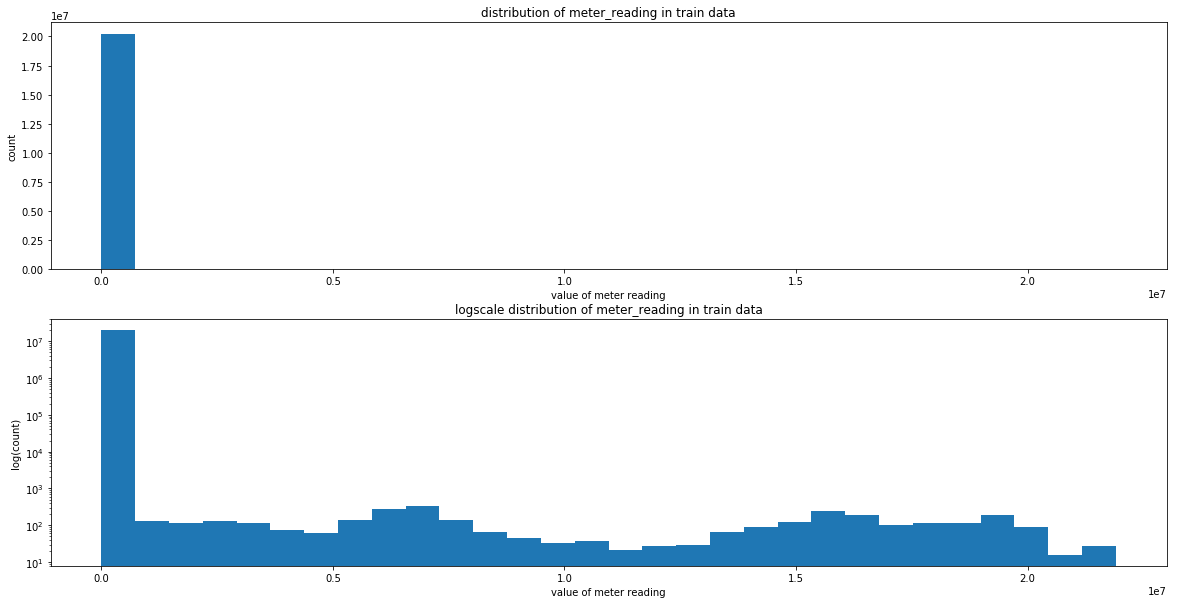

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.hist(train_df['meter_reading'],30)
plt.title('distribution of meter_reading in train data')
plt.xlabel('value of meter reading')
plt.ylabel('count')
plt.subplot(212)
plt.hist(train_df['meter_reading'],30)
plt.title('logscale distribution of meter_reading in train data')
plt.xlabel('value of meter reading')
plt.ylabel('log(count)')
plt.yscale('log')
plt.plot()

Many very low values, let's zoom in on the lower values

[]

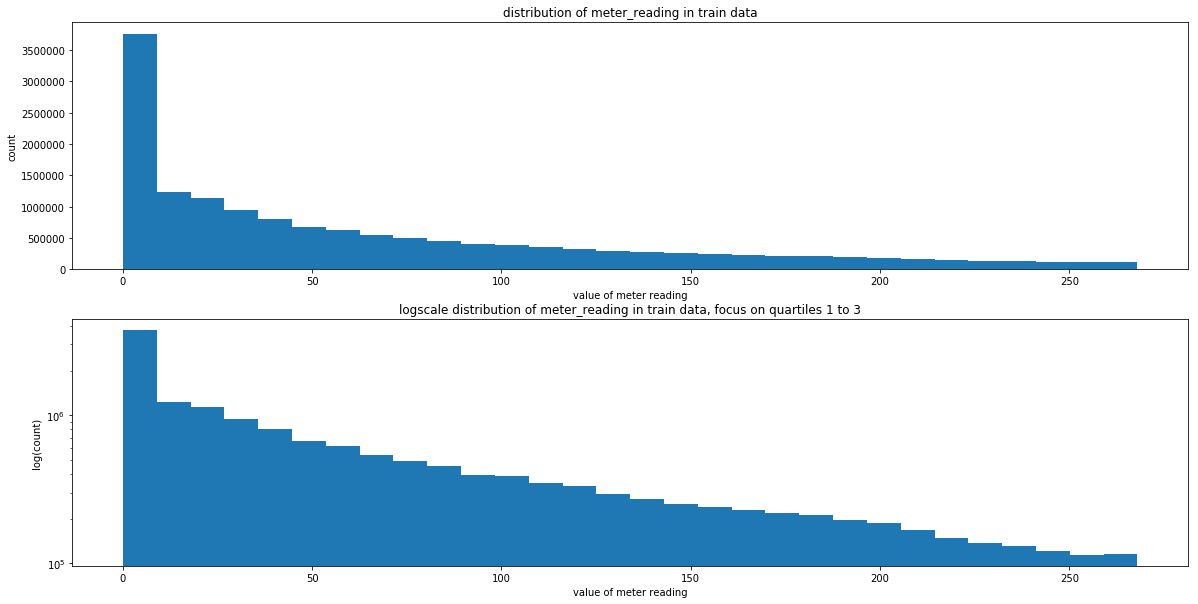

In [11]:
plt.figure(figsize=(20, 10))
plt.subplot(211)
plt.hist(train_df[train_df['meter_reading']<=268].meter_reading.dropna(),30)
plt.title('distribution of meter_reading in train data')
plt.xlabel('value of meter reading')
plt.ylabel('count')
plt.subplot(212)
plt.hist(train_df[train_df['meter_reading']<=268].meter_reading.dropna(),30)
plt.title('logscale distribution of meter_reading in train data, focus on quartiles 1 to 3')
plt.xlabel('value of meter reading')
plt.ylabel('log(count)')
plt.yscale('log')
plt.plot()

Still a high bar near zero, let's count actual zero reading in the training data

In [12]:
number_of_zero_readings = train_df[train_df['meter_reading']==0].meter_reading.count()
number_of_readings = train_df['meter_reading'].count()
print('there are ',100*number_of_zero_readings/number_of_readings,'% zero readings in train_data')

there are  9.269720668180312 % zero readings in train_data


### Comparing meter types

> There are four different meter types and are displayed below:
>     0: electricity
>     1: chilledwater
>     2: steam
>     3: hotwater

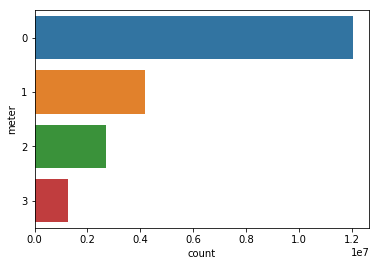

In [13]:
sns.countplot(y='meter',data = train_df)

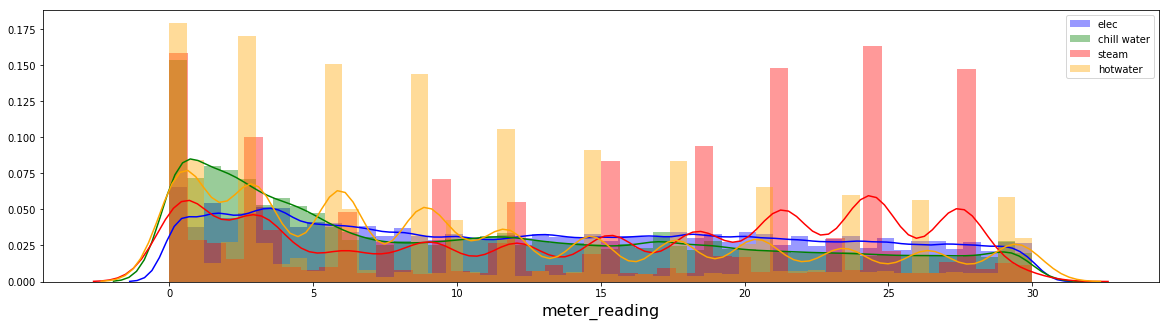

In [14]:
fig, ax = plt.subplots(figsize=(20, 5))

low_reading = train_df['meter_reading']<=30
nonnul_reading = train_df['meter_reading']!=0

electricity_reading = train_df['meter']==0
sns.distplot(train_df[low_reading & electricity_reading & nonnul_reading].meter_reading, color = 'blue',ax =ax)

chillwater_reading = train_df['meter']==1
sns.distplot(train_df[low_reading & chillwater_reading & nonnul_reading].meter_reading, color = 'green',ax =ax)

steam_reading = train_df['meter']==2
sns.distplot(train_df[low_reading & steam_reading & nonnul_reading].meter_reading, color = 'red',ax =ax)

hotwater_reading = train_df['meter']==3
sns.distplot(train_df[low_reading & hotwater_reading & nonnul_reading].meter_reading, color = 'orange',ax =ax)

plt.xlabel('meter_reading', fontsize=16)
plt.legend(['elec', 'chill water','steam','hotwater'])
plt.show()    

Notice that while electricity anbd chillwater are continuous, **steam and hotwater measurements are by step of approx 5**

## Weather data

### looking at weatehr data correlation

Mem. usage decreased to  3.07 Mb (68.1% reduction)


0

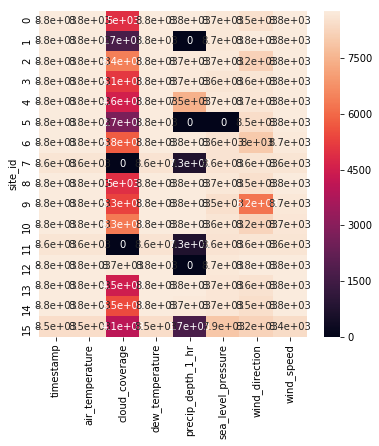

In [15]:
weather_train = reduce_mem_usage(pd.read_csv('../input/ashrae-energy-prediction/weather_train.csv'))
plt.figure(figsize = (6, 6))
sns.heatmap(weather_train.groupby('site_id').count(), annot = True)
# No precipitations data for site 1, 5 and 12
# No sea-level pressure for site 5
del weather_train
gc.collect()

### Distribution + comparing test & train data

In [16]:
def plot_distribution(train_df,test_df,column):
    fig, ax = plt.subplots(figsize=(20, 5))
    sns.distplot(train_df[column].dropna(), color = 'red',ax =ax).set_title(column,fontsize = 10)
    sns.distplot(test_df[column].dropna(), color = 'blue',ax =ax).set_title(column,fontsize = 10)
    plt.xlabel(column, fontsize=16)
    plt.legend(['training data', 'test data'])
    plt.show()

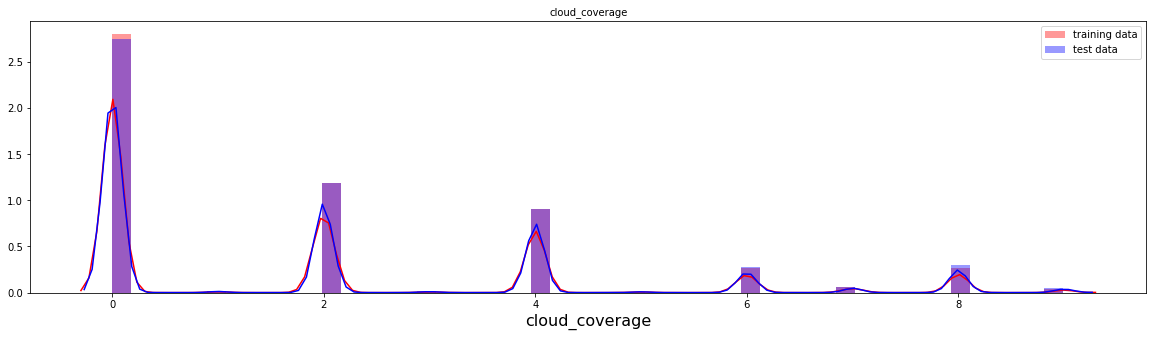

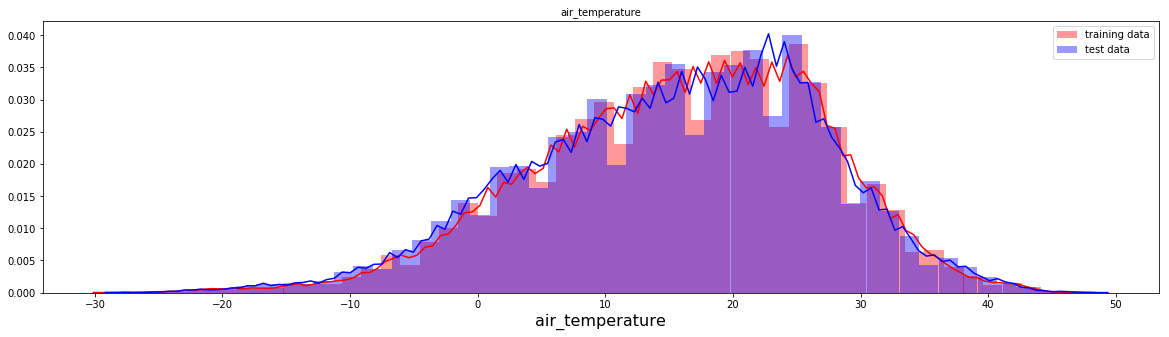

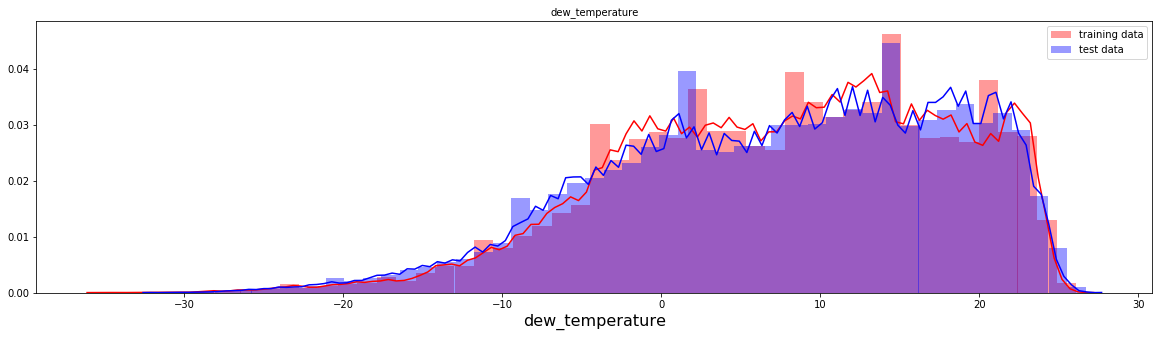

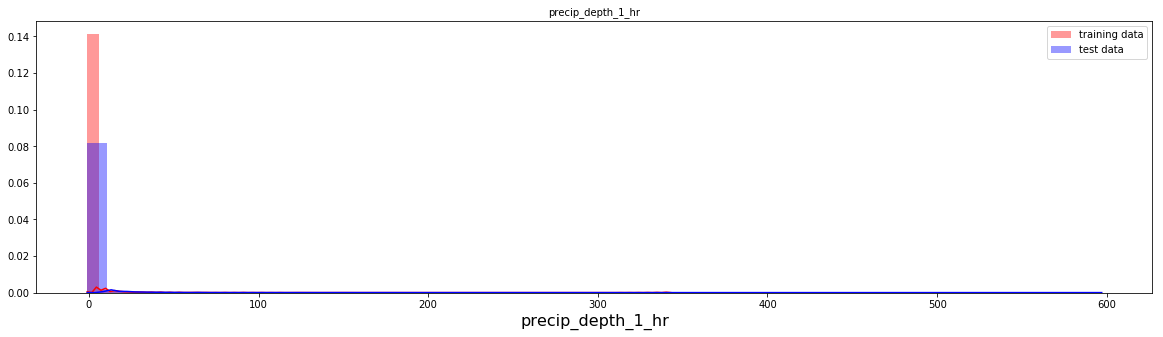

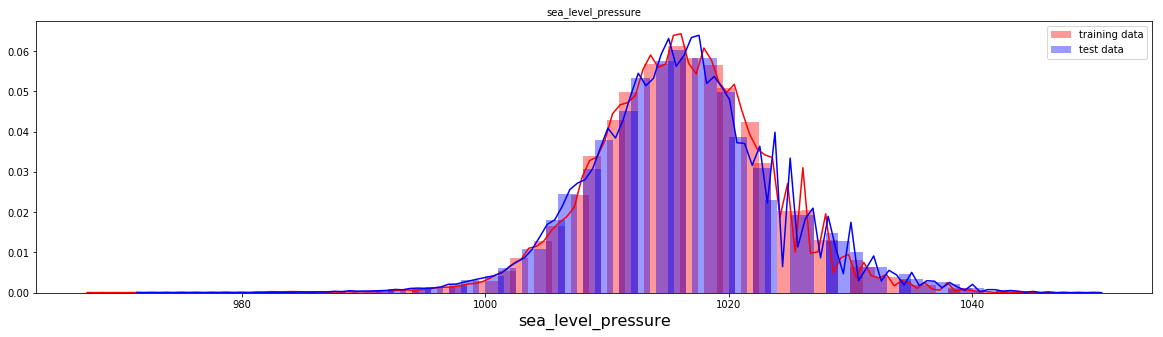

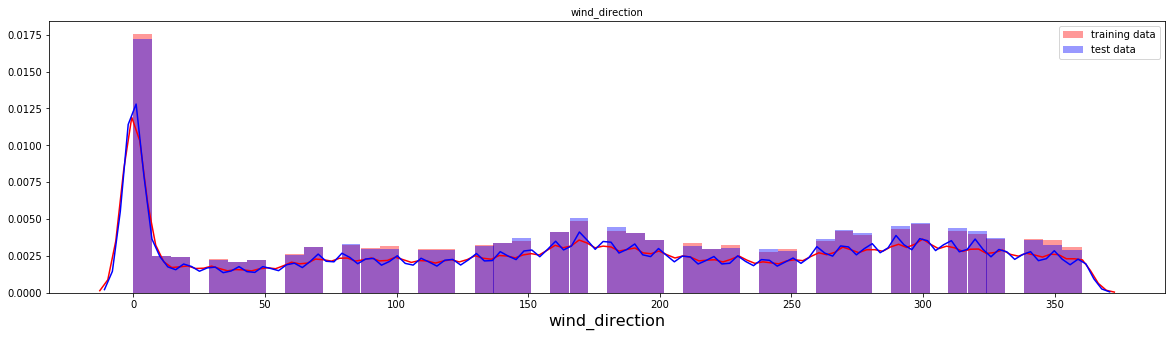

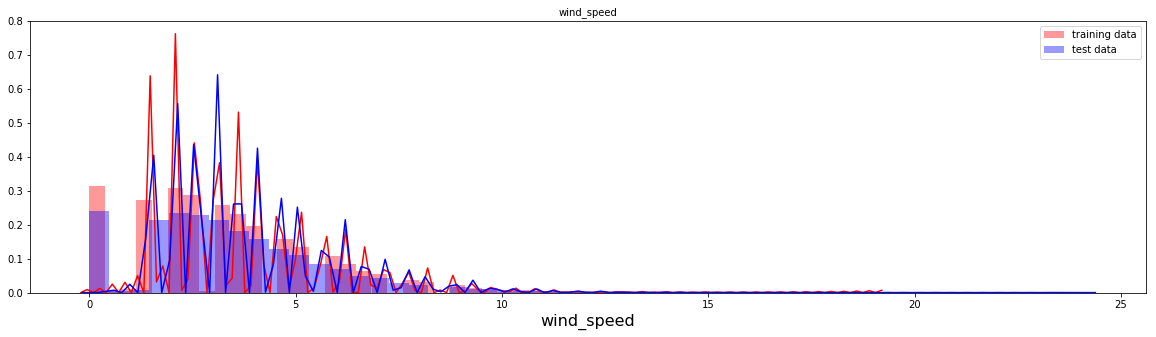

In [17]:
plot_distribution(train_df,test_df,'cloud_coverage')
plot_distribution(train_df,test_df,'air_temperature')
plot_distribution(train_df,test_df,'dew_temperature')
plot_distribution(train_df,test_df,'precip_depth_1_hr')
plot_distribution(train_df,test_df,'sea_level_pressure')
plot_distribution(train_df,test_df,'wind_direction')
plot_distribution(train_df,test_df,'wind_speed')

Distributions are similiar between test and learn data, except for precipitation -> handle with care

### Is it all in the northern hemisphere ?
Otherwise, might need to move data by 6 months for given site_id's

In [18]:
temp_df = train_df[['timestamp','building_id','site_id','air_temperature']].copy()
temp_df['date'] = temp_df.timestamp.dt.date
temp_df = temp_df.groupby(['site_id','date'],as_index=False).mean()

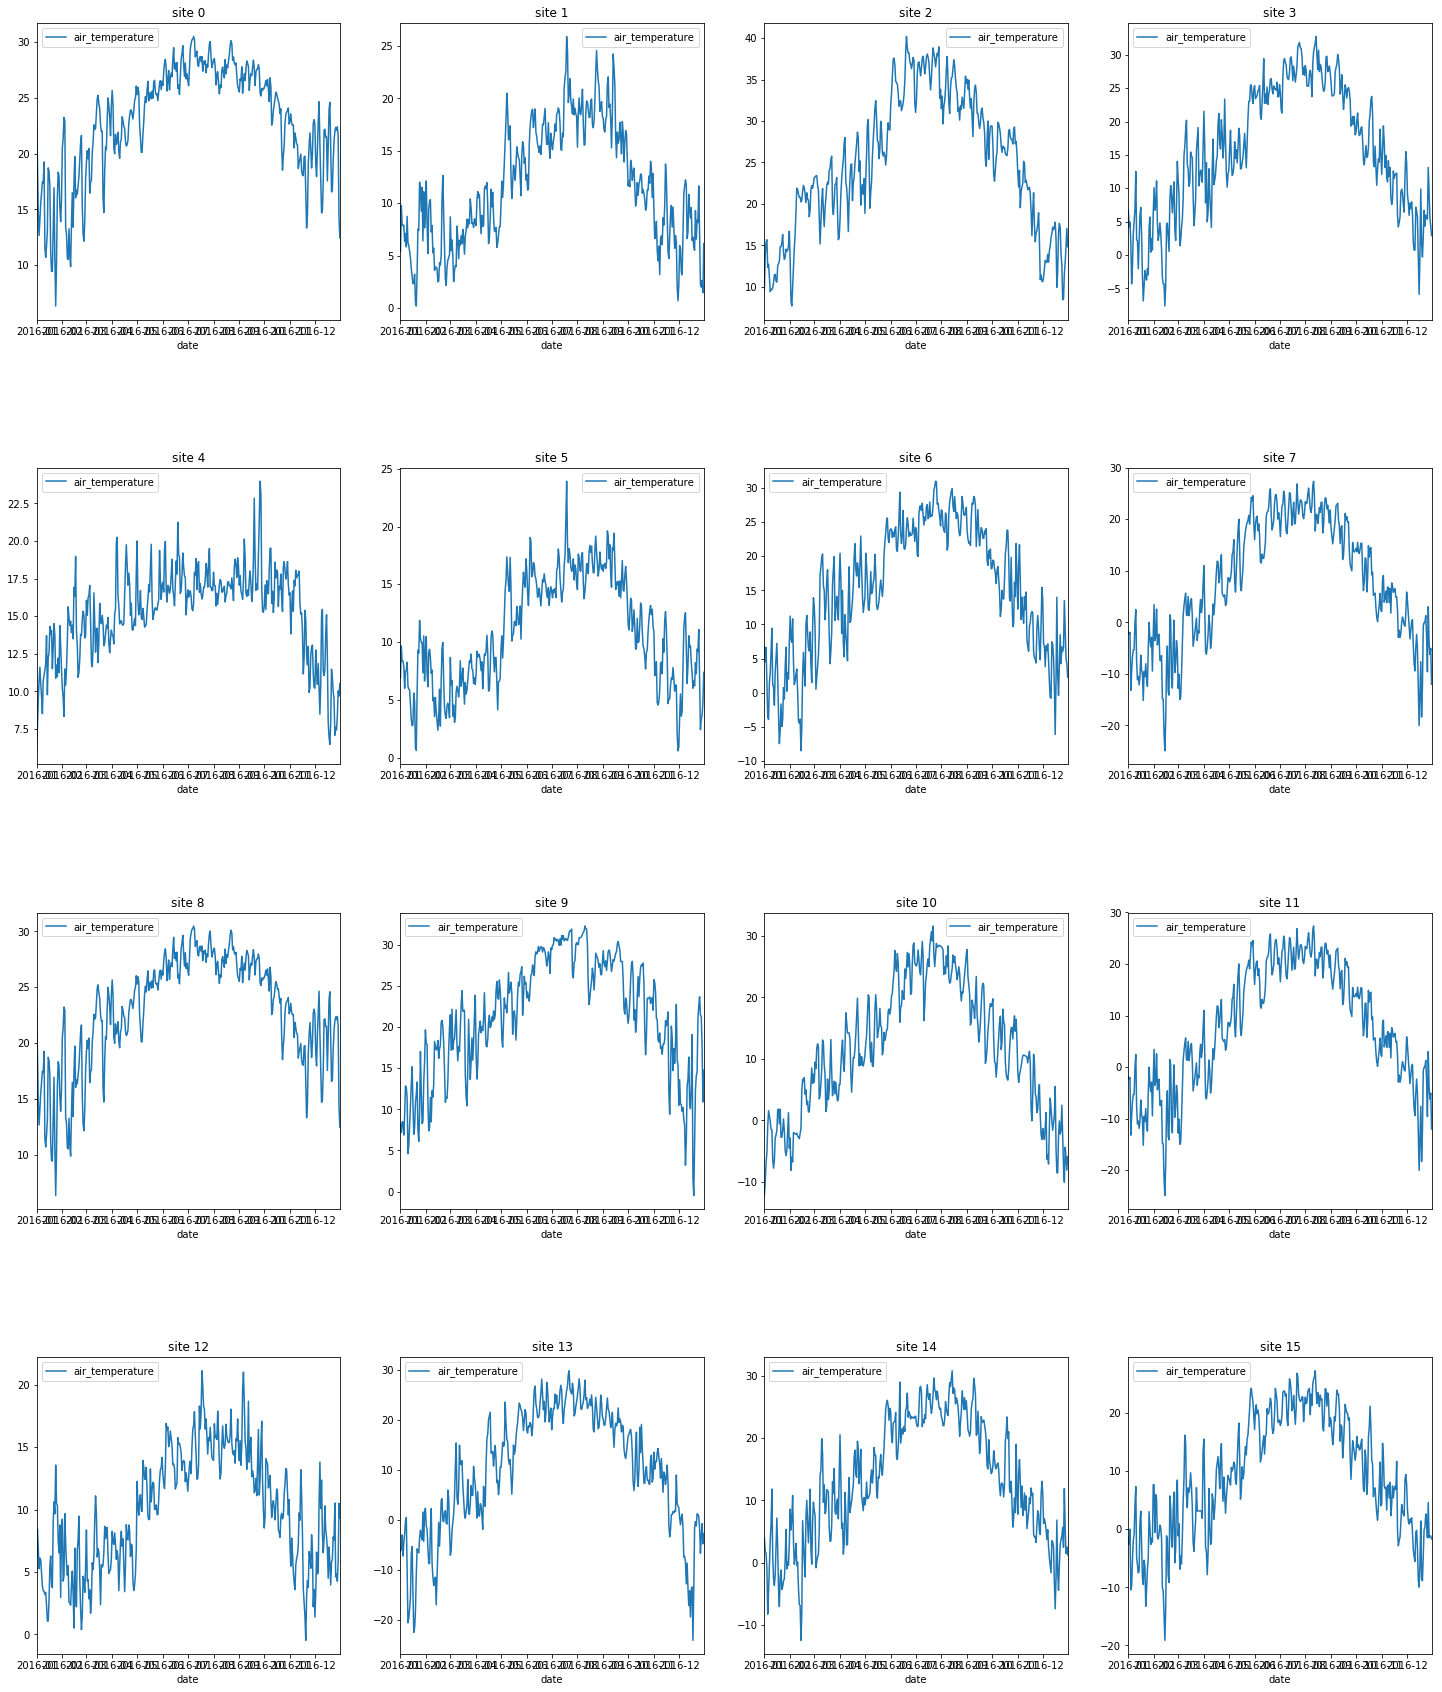

In [19]:
fig,ax=plt.subplots(4,4,figsize=(25,30))
plt.subplots_adjust(hspace=0.5)
for k in train_df.site_id.unique():
    temp_df[temp_df['site_id']==k].plot(x='date', y='air_temperature', ax=ax[(k//4),(k%4)], title=f'site {k}', figure=fig)

We can observe a few things :
* all peak in the middle of the year -> northen hemisphere
* there are some striking similarities between a few sites : 14,15,11,7,6 ahve the same freezing february day
ToDo : cluster the sites based on the distance between their air temperature to add a feature

In [20]:
del temp_df
gc.collect()

29316

# Looking for seasonality
idea : try to cluster buildings into climate types could improve model

In [21]:
#group per day of the week
weekday_group_df = train_df[['timestamp','meter_reading','primary_use','meter']].copy()
weekday_group_df['weekday'] = weekday_group_df['timestamp'].dt.weekday
weekday_group_df = weekday_group_df.groupby(['primary_use','meter','weekday'],group_keys=False,as_index=False).sum()
weekday_group_df = reduce_mem_usage(weekday_group_df)
weekday_group_df.head()

Mem. usage decreased to  0.01 Mb (38.9% reduction)


primary_use  meter  weekday  meter_reading
0   Education      0        0    165539024.0
1   Education      0        1    168636928.0
2   Education      0        2    169160688.0
3   Education      0        3    168917664.0
4   Education      0        4    167914816.0

In [22]:
weekday_group_df.shape

(364, 4)

In [23]:
primary_use_list = train_df['primary_use'].unique()
len(primary_use_list)

16

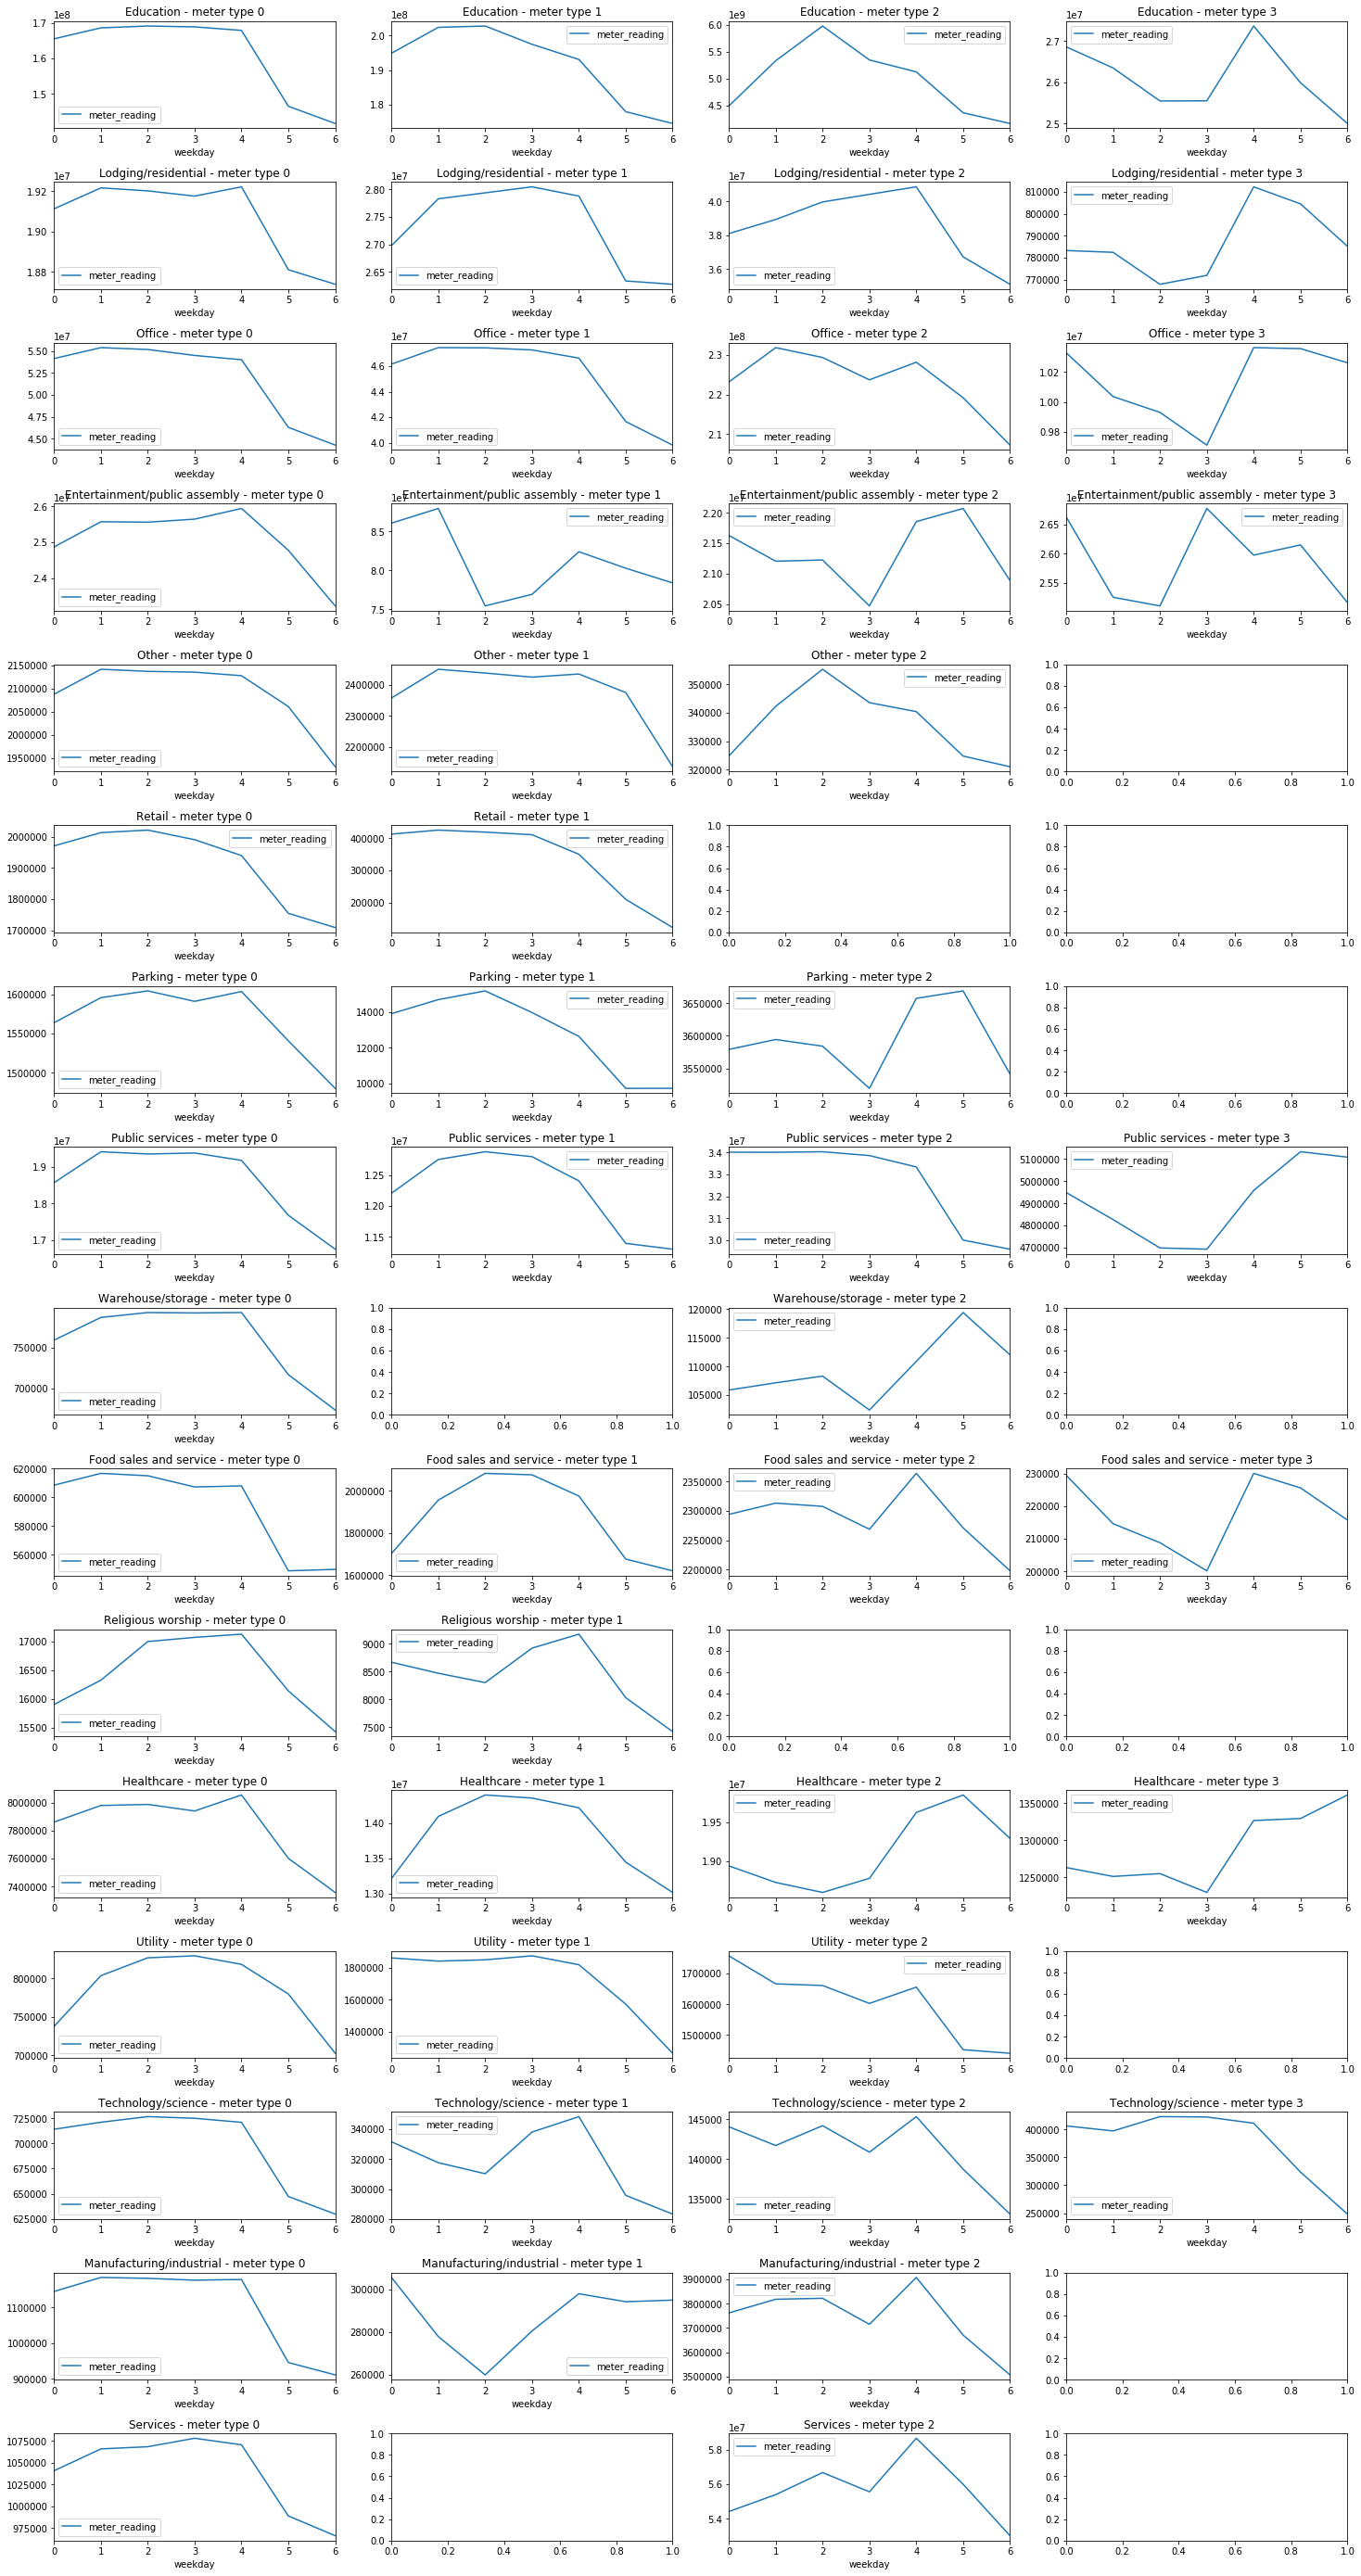

In [24]:
fig, ax = plt.subplots(16, 4,figsize=(25,50))
plt.subplots_adjust(hspace=0.5)
i=0
for use in primary_use_list:
    use_filter = weekday_group_df['primary_use']==use
    for k in range(0,4):
        meter_filter = weekday_group_df['meter']==k
        if weekday_group_df[use_filter & meter_filter].shape[0] != 0:
            weekday_group_df[use_filter & meter_filter].plot(x='weekday' , y='meter_reading' , ax=ax[i,k] , figure=fig , title=f'{use} - meter type {k}')
    i=i+1

We can observe :
* Strong weekly trends
* Different for each primary use and meter type
-> primary_use is a strongly descriptive variable

In [25]:
del weekday_group_df,i,fig,ax
gc.collect()

128387

## Per primary use

In [26]:
#group per day of the year
daily_group_df = train_df[['timestamp','meter_reading','primary_use','meter','site_id']].copy()
daily_group_df['date'] = daily_group_df['timestamp'].dt.date
daily_group_df = daily_group_df.groupby(['site_id','primary_use','meter','date'],group_keys=False,as_index=False).sum()
daily_group_df.head()

site_id primary_use  meter        date  meter_reading
0        0   Education      0  2016-01-01     433.131989
1        0   Education      0  2016-01-02     828.082092
2        0   Education      0  2016-01-03     395.622009
3        0   Education      0  2016-01-04     627.271912
4        0   Education      0  2016-01-05     272.341217

[]

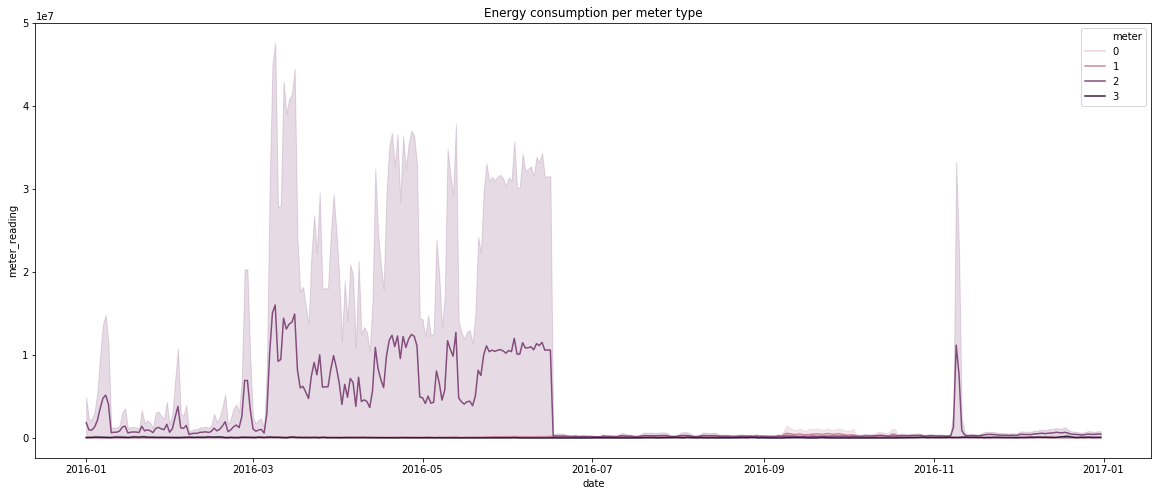

In [27]:
#let'ts look at yearly trends per meter type
plt.figure(figsize=(20,8))
ax = sns.lineplot(x='date', y="meter_reading", data=daily_group_df,hue = 'meter').set_title('Energy consumption per meter type')
plt.plot()

Electricity is the main source of energy, followed by steam. they are strongly seasonal

In [28]:
def plot_per_primary_use(df,primary_use):
    plt.figure(figsize=(20,8))
    ax = sns.lineplot(x='date', y="meter_reading", data=df[df['primary_use']==primary_use],hue = 'meter').set_title('Energy consumption per type for '+primary_use+' buildings')
    plt.plot()

In [29]:
primary_use_list = train_df['primary_use'].unique()
primary_use_list

array(['Education', 'Lodging/residential', 'Office',
       'Entertainment/public assembly', 'Other', 'Retail', 'Parking',
       'Public services', 'Warehouse/storage', 'Food sales and service',
       'Religious worship', 'Healthcare', 'Utility', 'Technology/science',
       'Manufacturing/industrial', 'Services'], dtype=object)

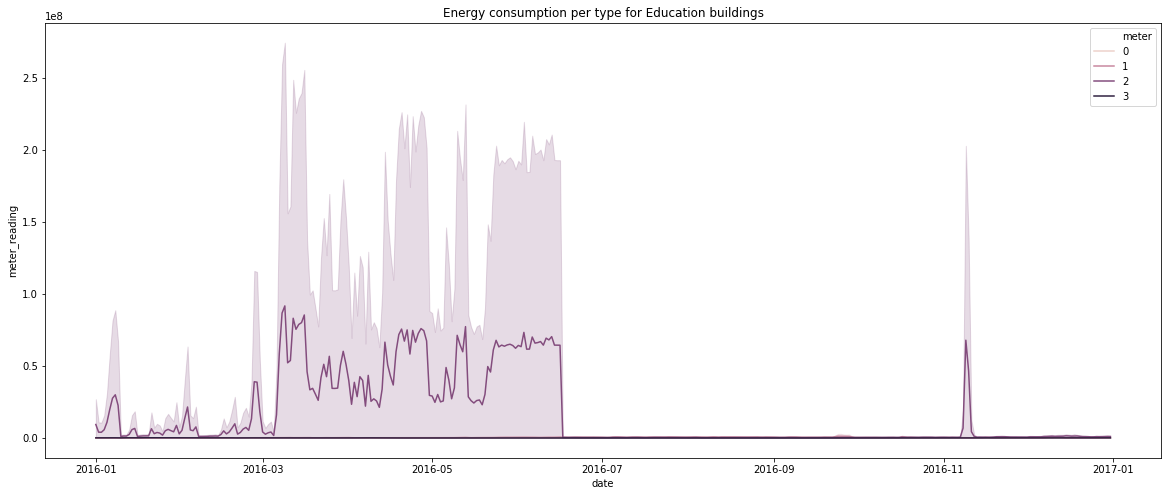

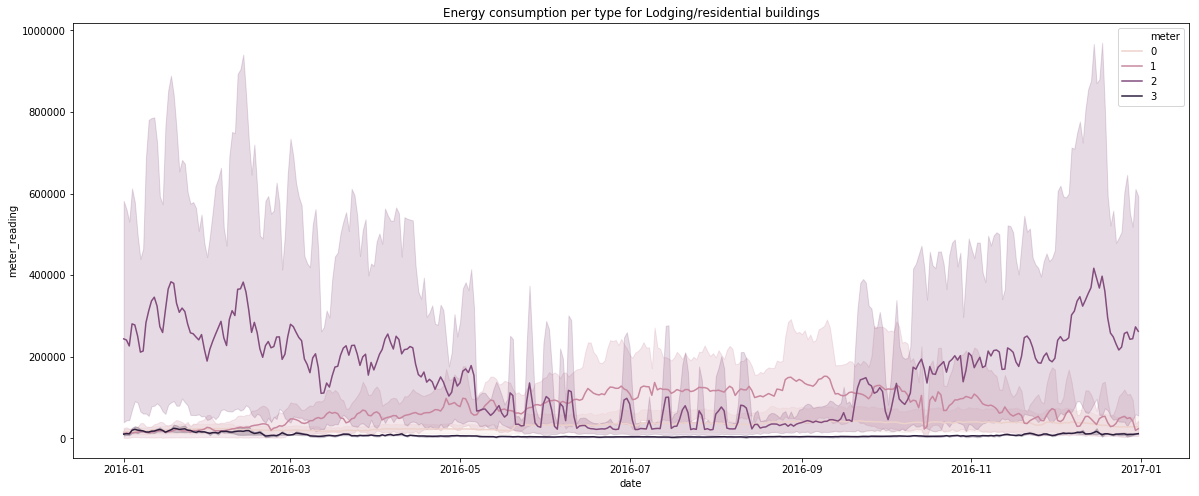

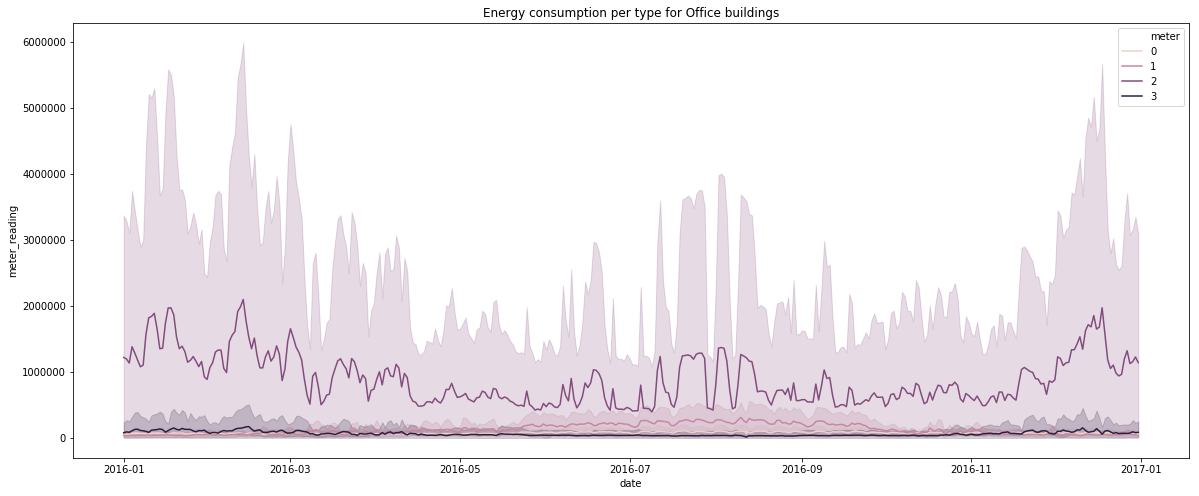

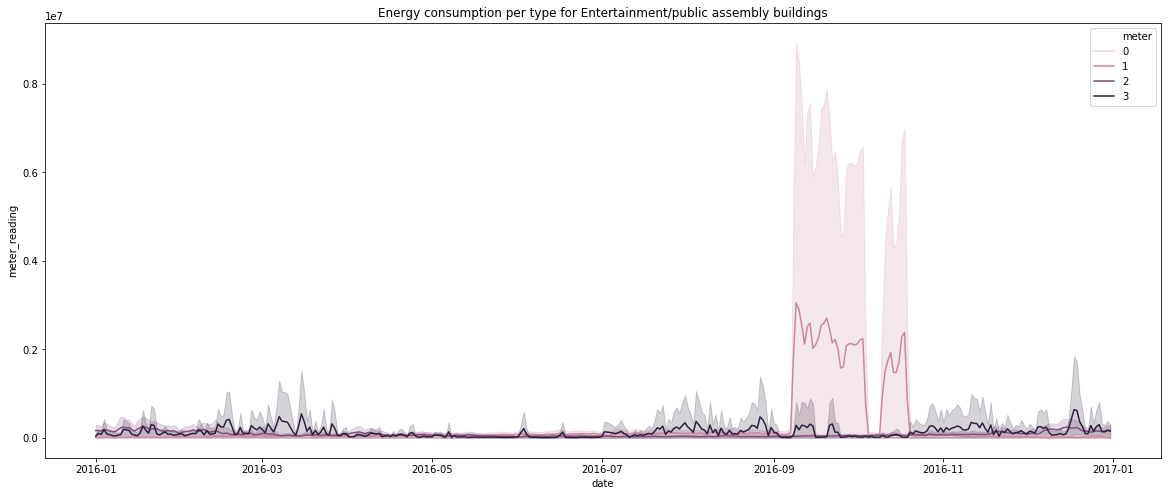

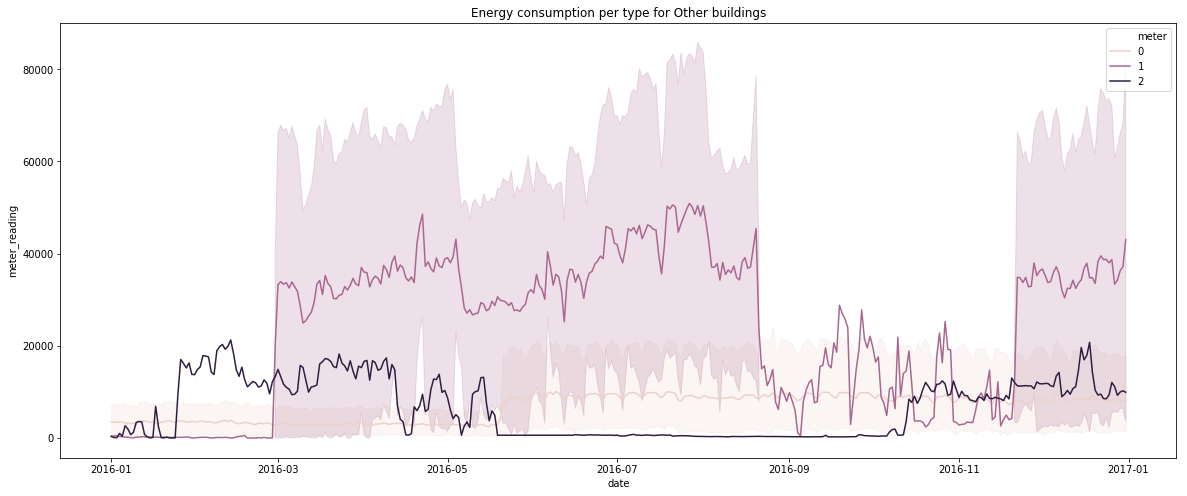

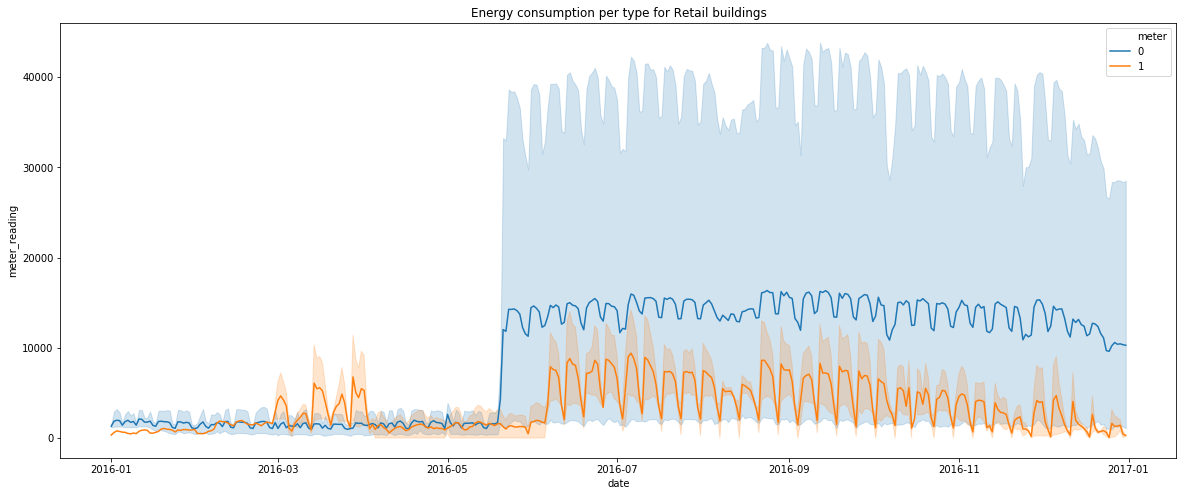

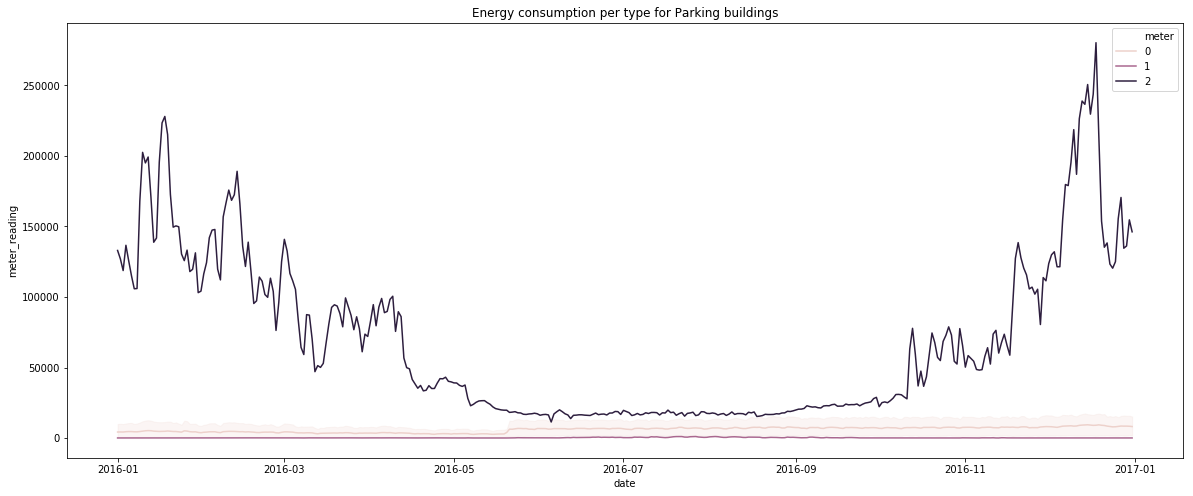

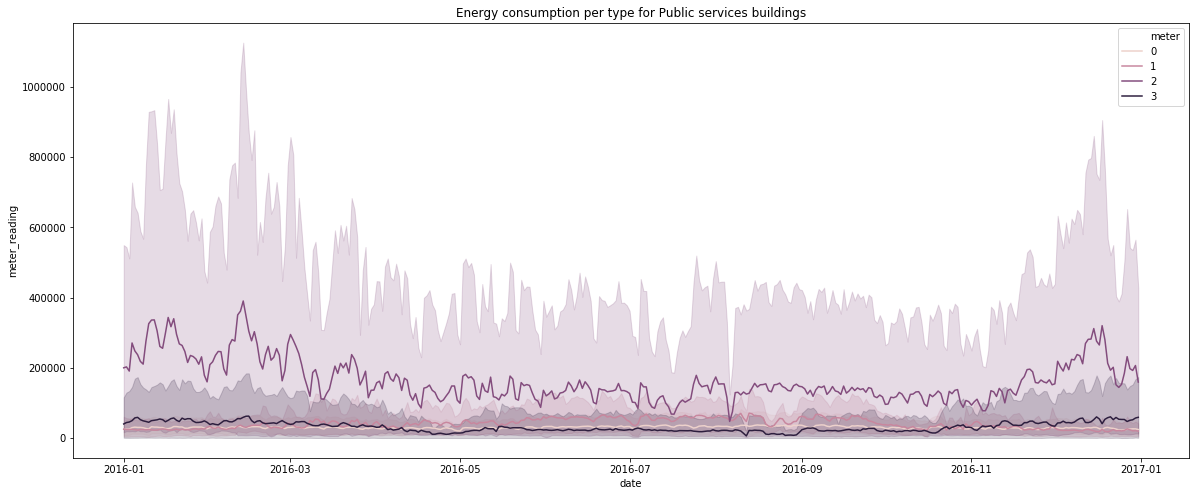

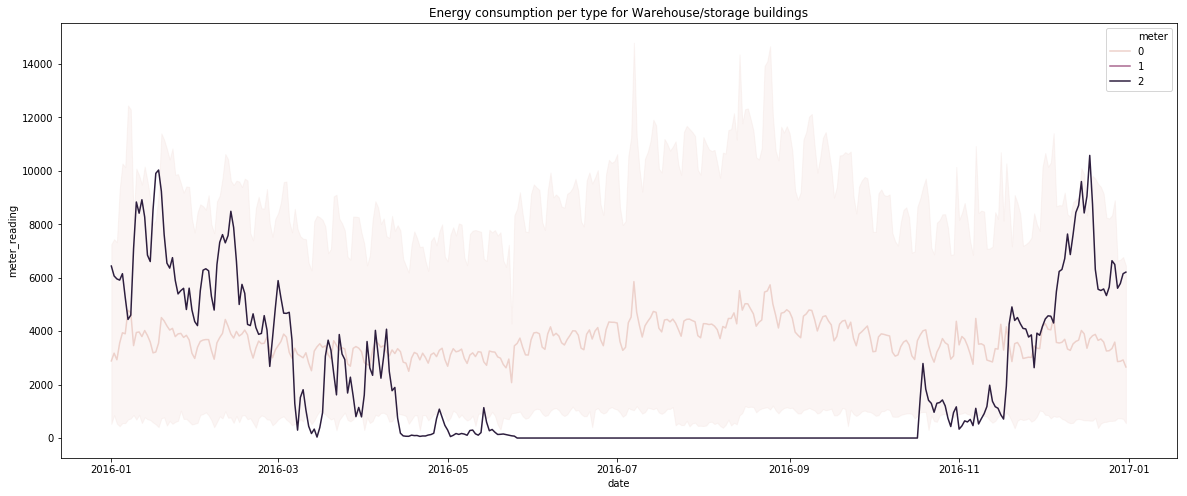

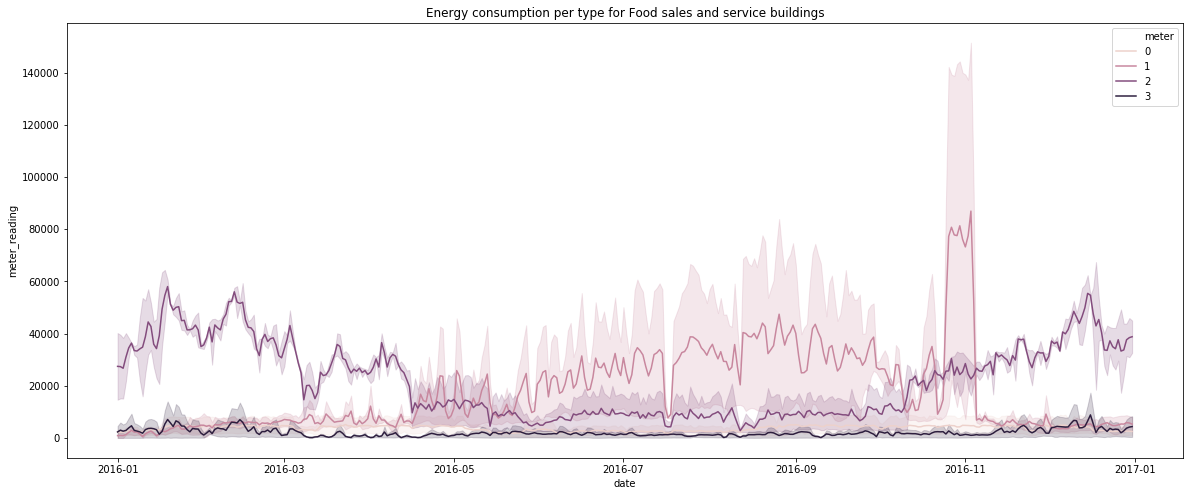

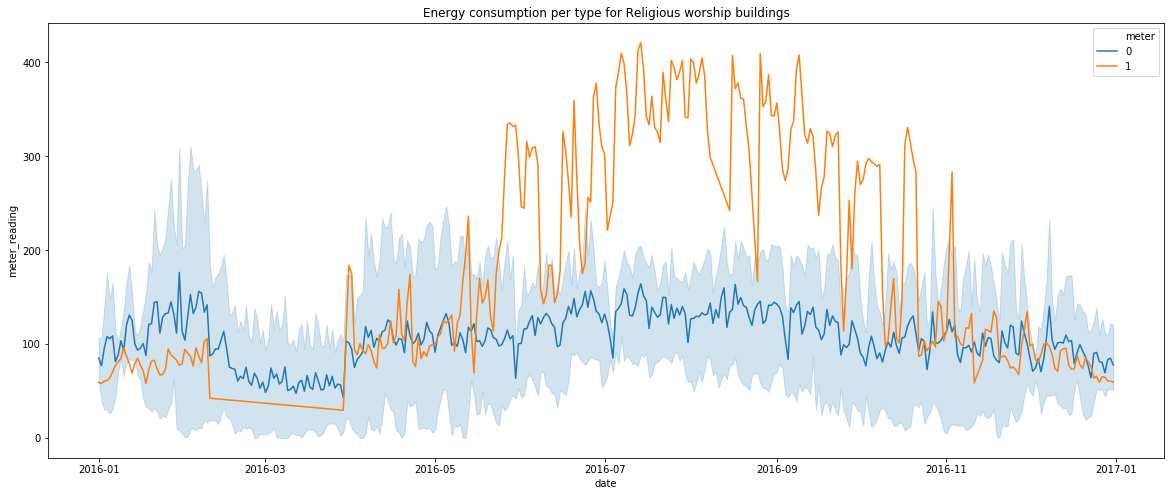

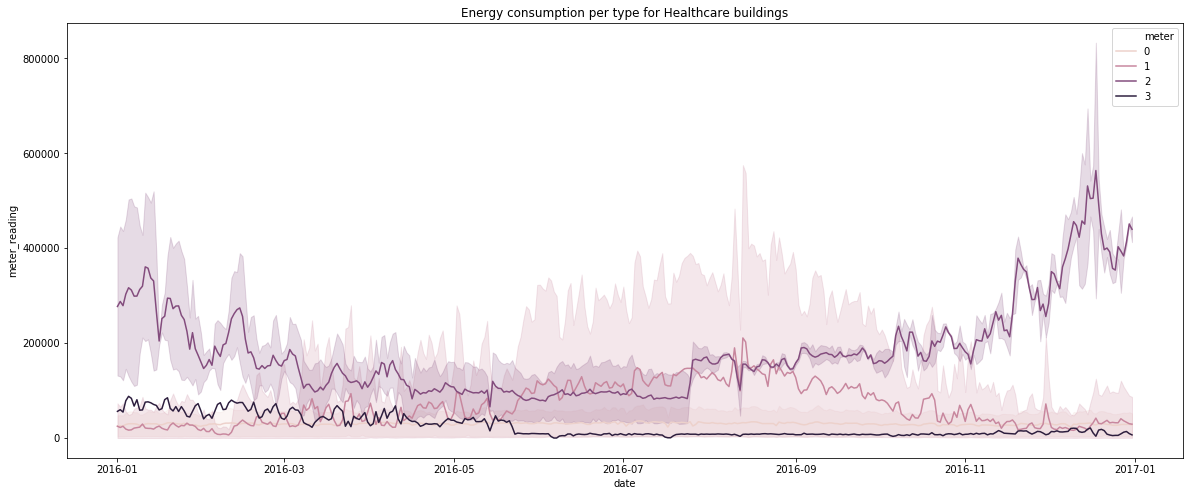

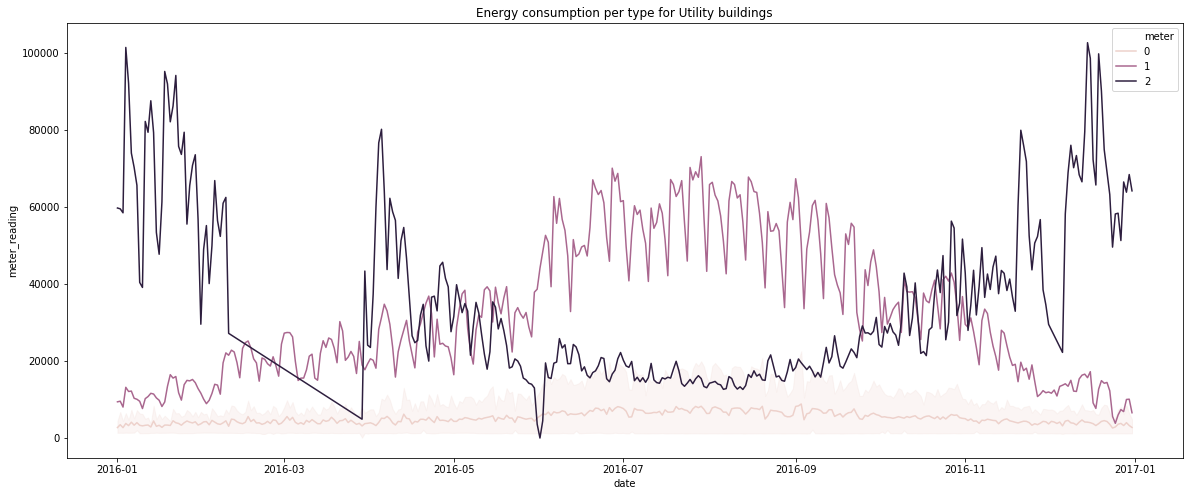

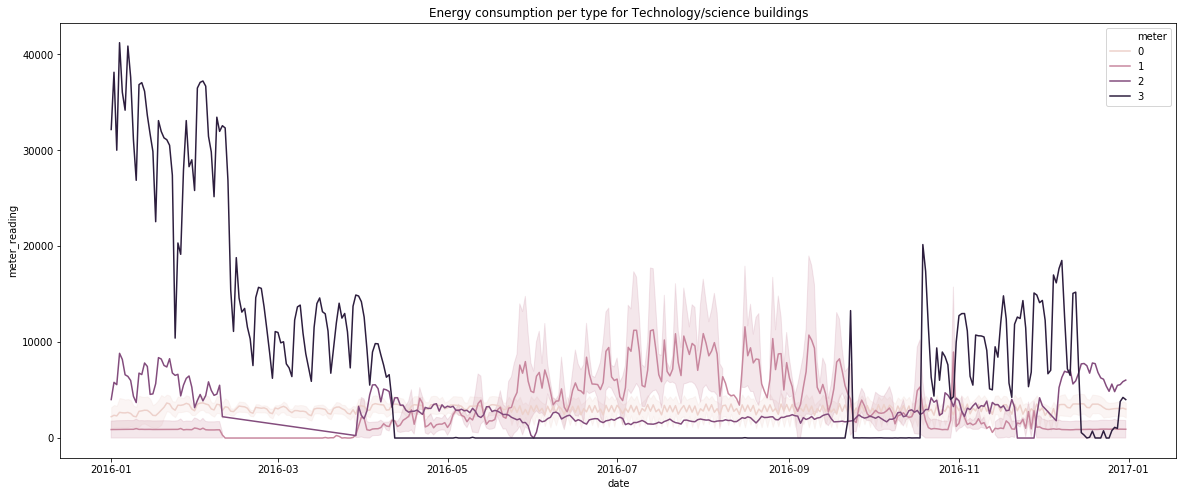

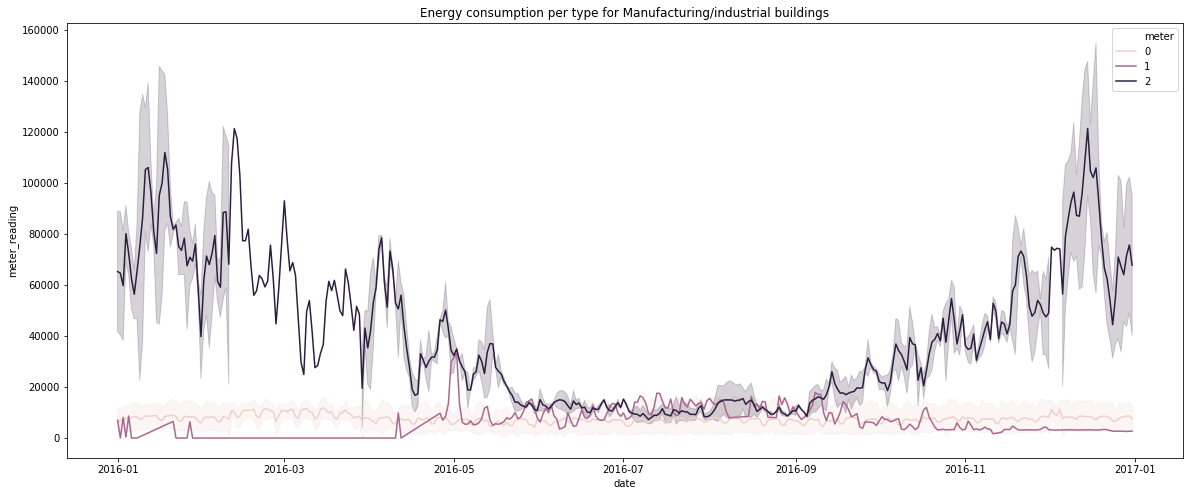

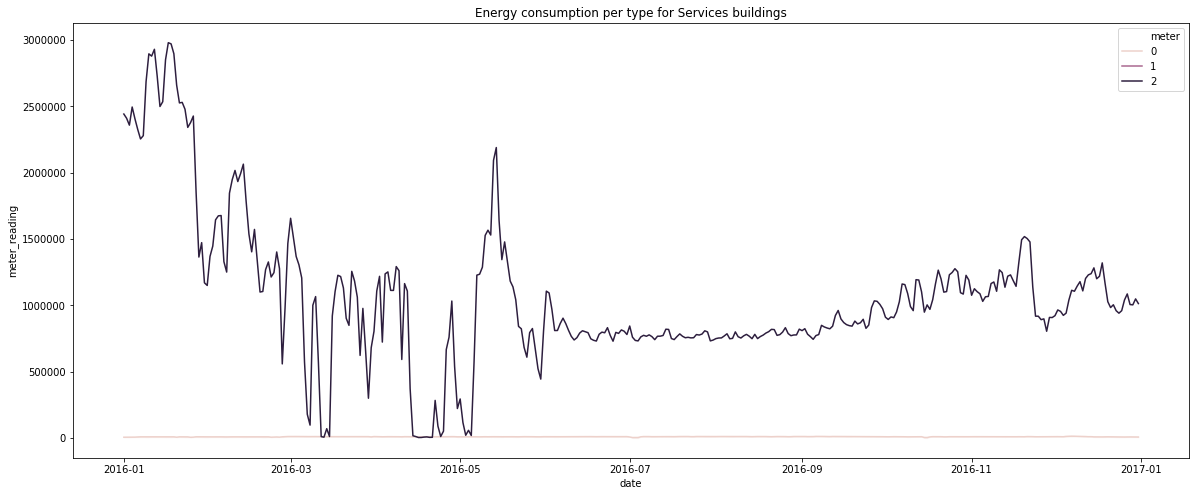

In [30]:
for primary_use in primary_use_list:
    plot_per_primary_use(daily_group_df,primary_use)

## Per site ID (geography)

In [31]:
colour_palette_16=sns.color_palette(n_colors=16)
colour_palette_4=sns.color_palette(n_colors=4)

[]

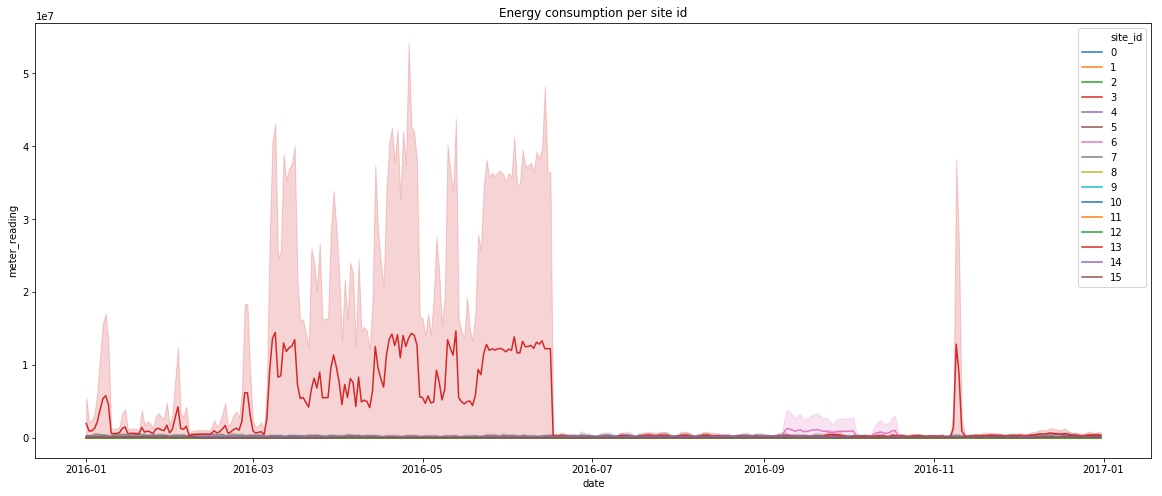

In [32]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(x='date', y="meter_reading", data=daily_group_df,hue = 'site_id',legend= 'full',palette = colour_palette_16).set_title('Energy consumption per site id')
plt.plot()

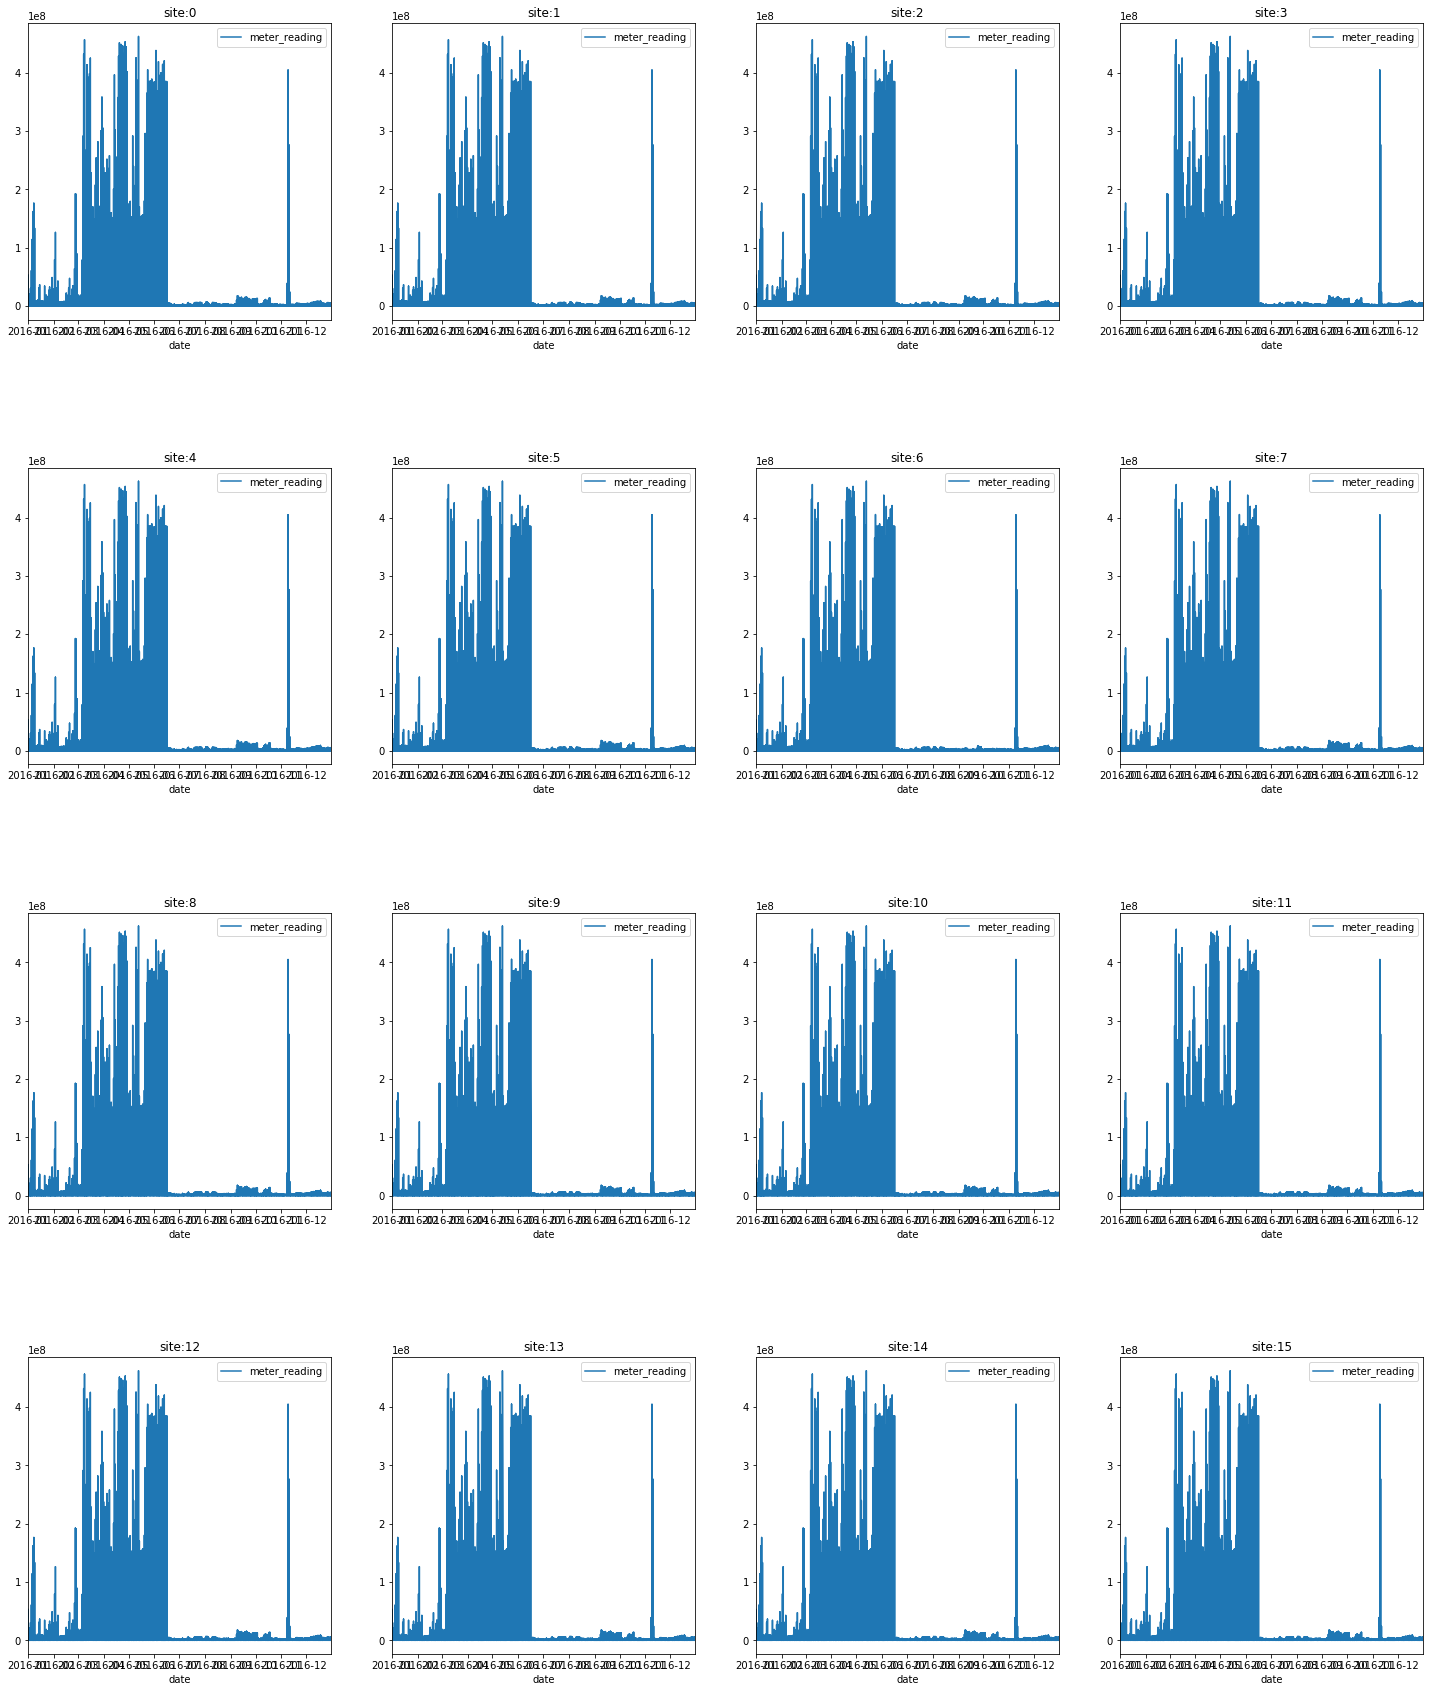

In [33]:
fig, ax = plt.subplots(4, 4,figsize=(25,30))
plt.subplots_adjust(hspace=0.5)
for i in range(0,16):
    daily_group_df[(daily_group_df.site_id==i) & daily_group_df.meter==0].plot(y='meter_reading',x='date',title=f'site:{i}',figure=fig,ax=ax[(i//4),(i%4)])

In [34]:
def plot_per_site_id(df,site_id):
    plt.figure(figsize=(20,5))
    ax = sns.lineplot(x='date', y="meter_reading", data=df[df['site_id']==site_id],hue = 'meter').set_title('Energy consumption per type for '+str(site_id)+' site id')
    plt.plot()

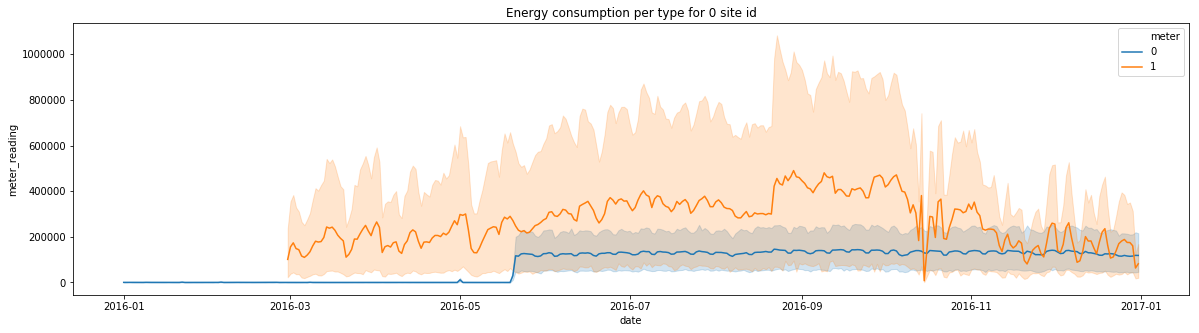

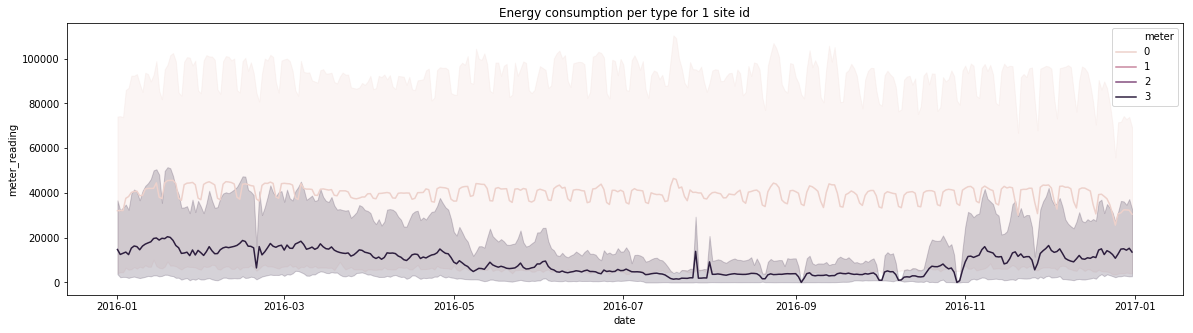

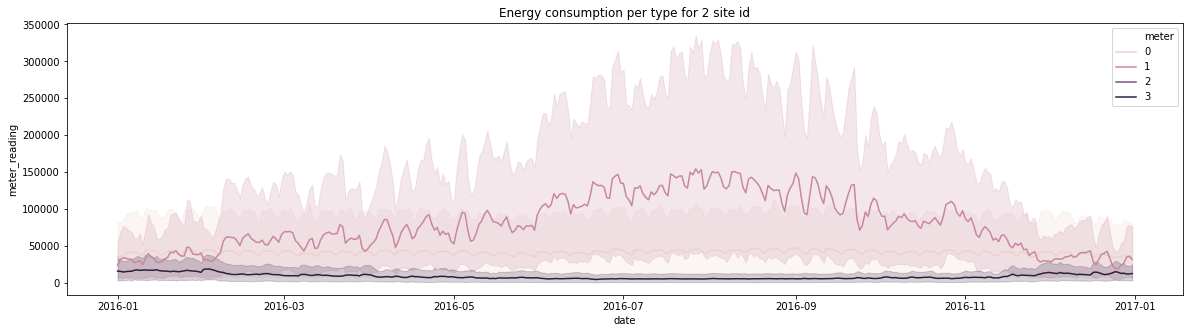

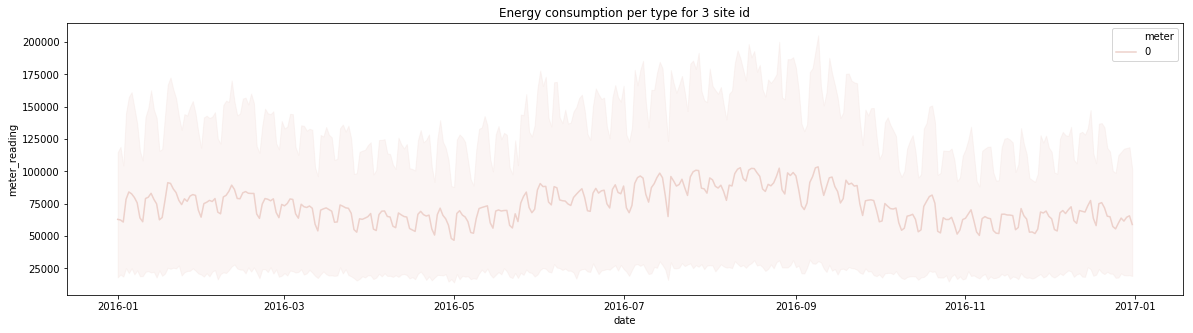

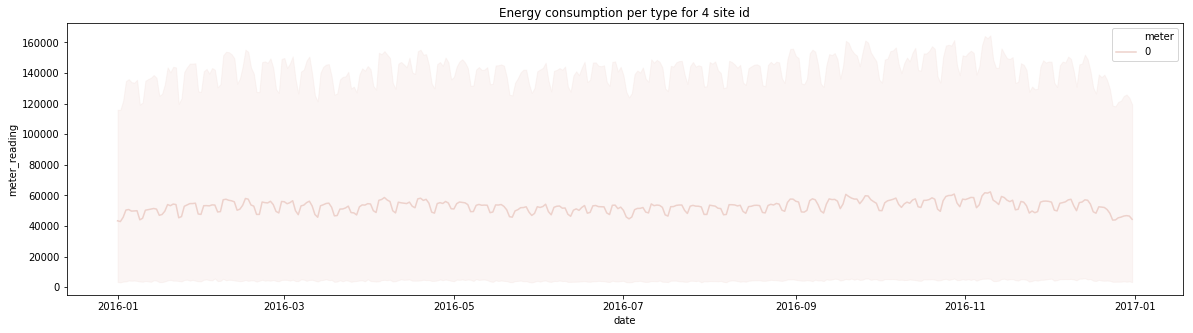

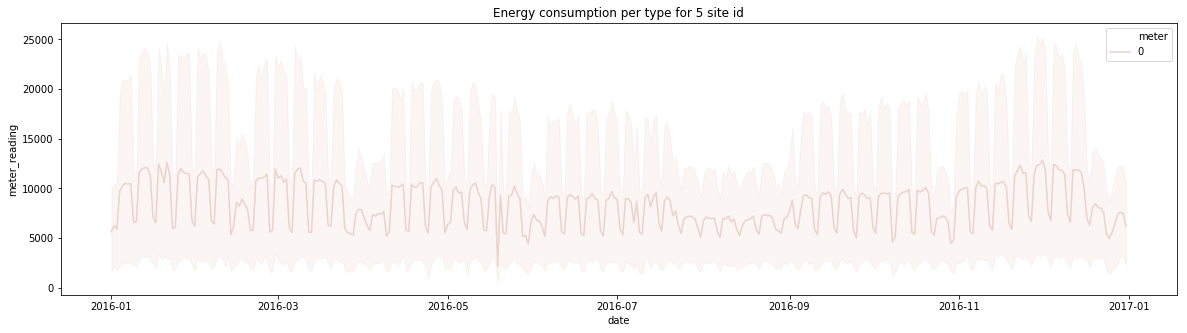

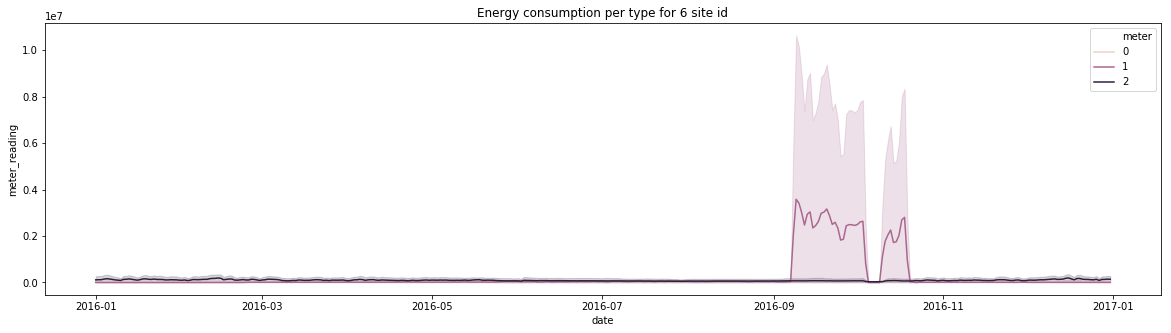

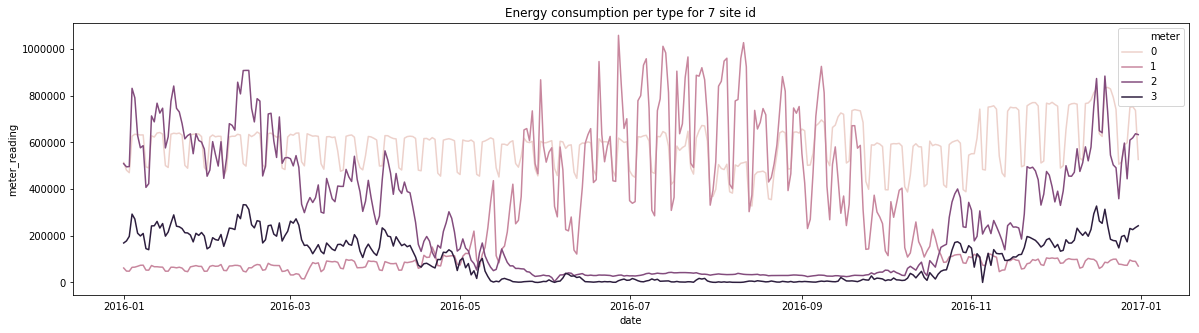

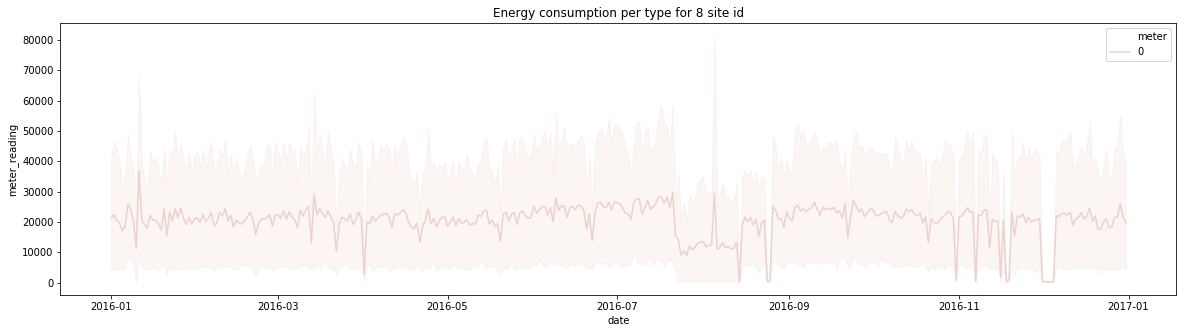

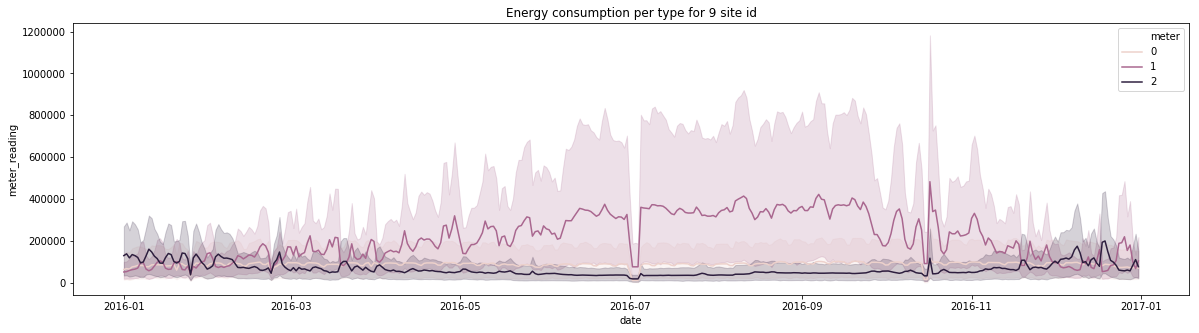

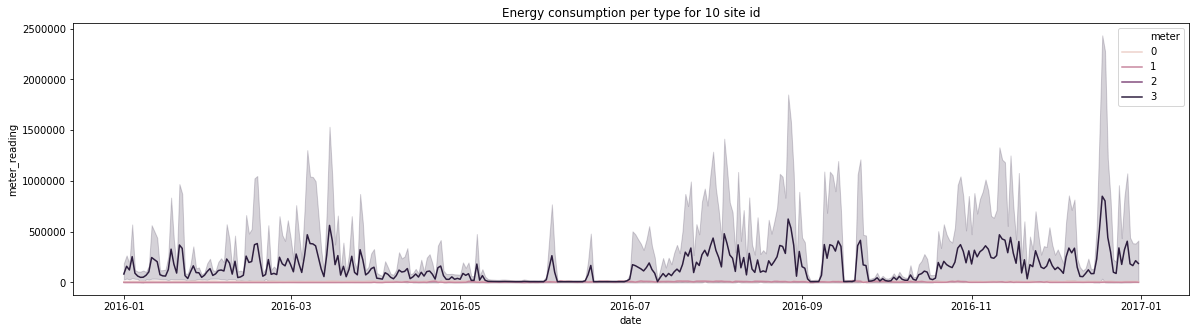

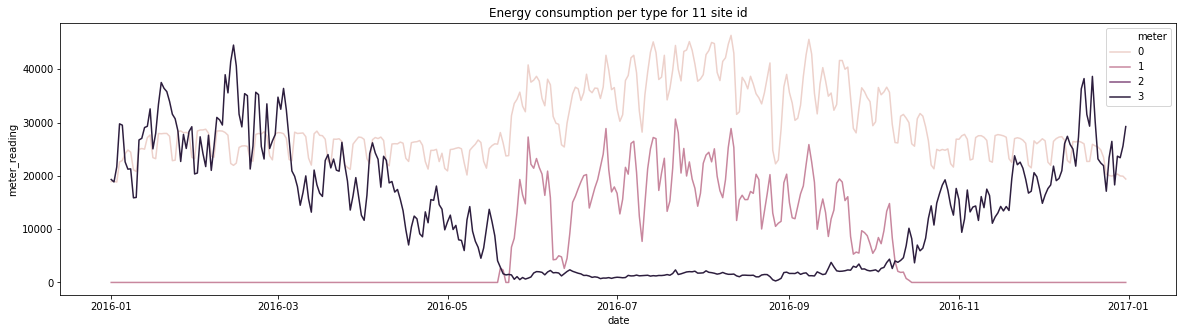

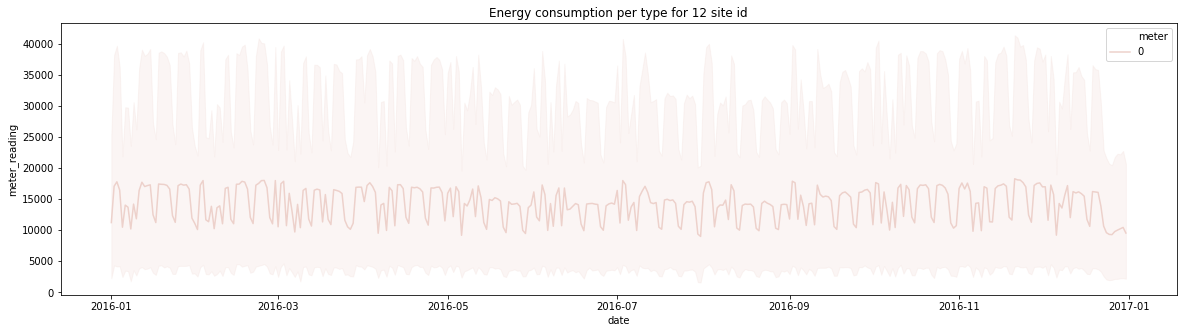

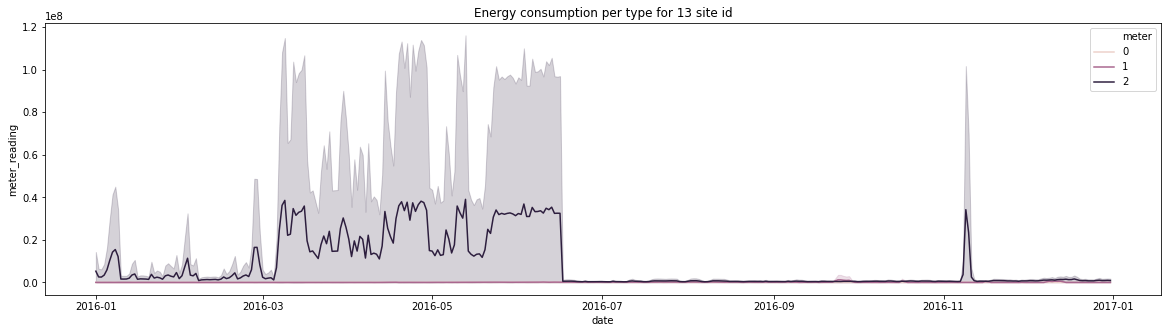

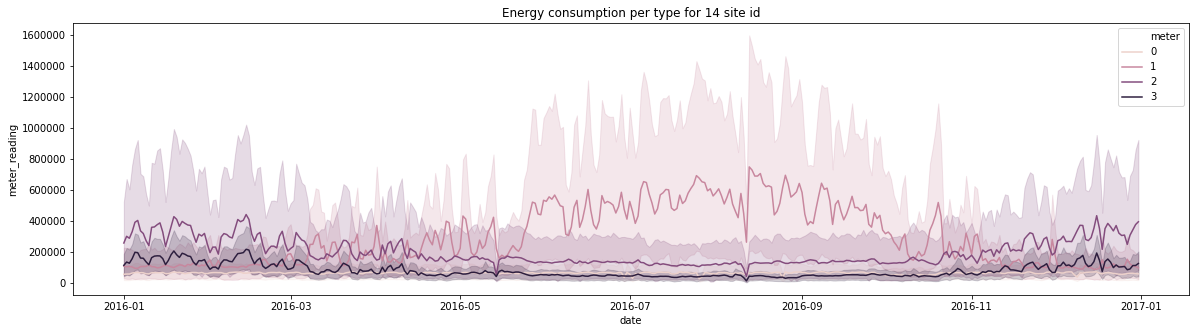

In [35]:
for n in range(0,15):
    plot_per_site_id(daily_group_df,site_id=n)

In [36]:
del daily_train_df
gc()

NameError: name 'daily_train_df' is not defined

# NA values processing

#### Where do we have missing values ?

#% of missing values
100*train_df.isna().sum()/train_df.shape[0]

#let's check test data
100*test_df.isna().sum()/test_df.shape[0]

Similar missing values for train and test

#for now let's drop them
NA_cols = ['year_built','floor_count','cloud_coverage','precip_depth_1_hr']
test_df.drop(NA_cols,axis=1,inplace=True)
train_df.drop(NA_cols,axis=1,inplace=True)

#### for the other ones, let's fill with mean value

few_NA_cols = ['air_temperature','dew_temperature','sea_level_pressure','wind_direction','wind_speed']

#fill brutally with column mean, need to find better segmentation
for col in few_NA_cols:
    train_df[col].fillna(train_df[col].mean,inplace=True)
    test_df[col].fillna(test_df[col].mean,inplace=True)

#% of missing values in train
100*train_df.isna().sum()/train_df.shape[0]

#let's check test data
100*test_df.isna().sum()/test_df.shape[0]

#I need to group the data by building for interpolation to make sense
#ToDo : make dict with all NA n% over 40%
#maxed_bluidings ={}
for col in few_NA_cols:
    max_NA = 0
    for building_k in train_df['building_id'].unique():
        only_building_k = train_df['building_id']==building_k
        temp = max(100*train_df[only_building_k].isna().sum()/train_df[only_building_k].shape[0])
        if temp > 40:
            max_NA=temp
            maxed_building = building_k
            maxed_buildings[building_k]=max_NA
    print('in column ',col)
    print('Maximum % of missing values for a same building is : ',max_NA)
    print('Achieved by :',maxed_building)

def interpolate_NA_values(df,column):
    temp_df = df.groupby('building_id')[column].interpolate()
    #for building_k in range(0,df['building_id'].unique):
    #    only_building_k = df['building_id']==building_k
    #    df[only_building_k].column.interpolate()
    return temp_df

train_df = interpolate_NA_values(train_df,'air_temperature')

100*train_df.isna().sum()/train_df.shape[0]

#### Weather - done above

In [37]:
# For the following fillings, I was thinking to add another separation into Morning / Afternoon / Evening / Night, in case there could be cycles of the data
#weather_train['sea_level_pressure'] = weather_train.groupby('site_id').transform(lambda x: x.fillna(x.mean()))['sea_level_pressure']
#weather_train['air_temperature'] = weather_train.groupby('site_id').transform(lambda x: x.fillna(x.mean()))['air_temperature']
#weather_train['dew_temperature'] = weather_train.groupby('site_id').transform(lambda x: x.fillna(x.mean()))['dew_temperature']
#weather_train['wind_direction'] = weather_train.groupby('site_id').transform(lambda x: x.fillna(x.mean()))['wind_direction']
#weather_train['wind_speed'] = weather_train.groupby('site_id').transform(lambda x: x.fillna(x.mean()))['wind_speed']

# MUST BE LAST ACTION 
# Sea-level pressure : WW mean = 1013.25 (https://en.wikipedia.org/wiki/Atmospheric_pressure)
#weather_train.fillna(1013.25, inplace = True)

# Features generation

In [38]:
# Year were the building was built. Arbitrary thresholds for now.
#train_df['is_old'] = train_df['year_built'] <= 1990
#buildings['is_very_old'] = buildings['year_built'] <= 1950
#buildings.drop('year_built', axis = 1, inplace = True) #@greg why drop it ?

In [39]:
# Number of floors. I've tried to distinguish buildings with relatively big and small floors.
#buildings_floor = buildings.dropna()[['square_feet', 'floor_count']]
#buildings_floor['avg_area'] = buildings_floor['square_feet'] / buildings_floor['floor_count']
#avg_area = buildings_floor['avg_area'].mean()
#avg_area

In [40]:
#buildings['big_floors'] = (buildings['square_feet'] / buildings['floor_count']) > 3 * avg_area
#buildings['small_floors'] = (buildings['square_feet'] / buildings['floor_count']) < avg_area / 3
#buildings['few_floors'] = buildings['floor_count'] == 1
#buildings['many_floors'] = buildings['floor_count'] >= 8
#buildings.drop('floor_count', axis = 1, inplace = True)